__Warning__
********************************

_LSFMs only evaluate SFs for a fixed target policy that selects actions uni-formly at random.  The learned model can then be used to predict the valuefunction of any arbitrary policy, including the optimal policy._

_LSFMs do not include a value prediction module_

_test different alpha for the loss_ : results : alpha_N = 1.0 / alpha_psi = 0.01

*********************************

__BUGS__
Attention : ne pas faire de _reset_LSFM_ : probleme d'allocation de nouveau tenseur je pense

# Commits and folder name

hidden layer dimension (LSFM or DQN) = latent layer dimension = dim origine state space / .....

Smaller env

In [1]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%Y-%m-%d_%Hh-%Mm-%Ss")
print("date and time =", dt_string)

In [2]:
folder_WORK = "LSFM_V2.5_dim1.2-hidden_ratio_2"+dt_string

# Environment

In [3]:
import gym
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, Input

from tensorflow.keras.layers import Lambda


import random
import numpy as np
import datetime as dt
import math

import pandas as pd
import seaborn as sns
sns.set()


import matplotlib.pyplot as plt
from gridworld import SimpleGrid

tf.keras.backend.floatx()

tf.keras.backend.set_floatx('float32')
tf.keras.backend.floatx()


'float32'

In [4]:
class custom_env:

    def __init__(self, env_name, param={}, state_dim = None, action_dim=None):
        # Initialize atributes
        self.env_name = env_name    # name of environment
        self.param = param          # dictionarry of environment parameters

        if (self.env_name == "SimpleGrid"):
            self.env = SimpleGrid(self.param["grid_size"],
                                  block_pattern=self.param["pattern"],
                                  obs_mode=self.param["obs_mode"])

            self.state_space = gym.spaces.Discrete(4)
            self.env.reset(
                agent_pos=self.param["agent_pos"], 
                goal_pos=self.param["goal_pos"],
                reward_pos=self.param["reward_pos"],
                reward_minmax = self.param["reward_minmax"],
                reward_user_defined = self.param["reward_user_defined"]
            )

            self.state_type = "Discrete"
            self.observation_space = gym.spaces.Discrete(
                self.param["grid_size"]**2)
            
            self.action_space = gym.spaces.Discrete(4)
            self._action_dim = self.action_space.n
            
            
        if (self.env_name.split("_")[0] == "gym"):
            gym_name = "_".join(self.env_name.split("_")[1:])
            self.env = gym.make(gym_name)
            self.action_space = self.env.action_space
            self._action_dim = self.action_space.n
            if (type(self.env.observation_space) == gym.spaces.discrete.Discrete):
                self.observation_space = self.env.observation_space
                self.state_type = "Discrete"
                                
            else:
                self.state_type = "Continue"

        if (self.env_name == "custom"):
            
            self._action_dim = action_dim
            self._state_dim = int(state_dim)
            
            self.state_type = "custom"
            observation = np.random.uniform(low=0., high=1., size=(state_dim,))
            
        else :            
            observation = self.reset()
        
        if self.state_type == "Discrete":
            self._state_dim = int(self.observation_space.n)
        else:
            self._state_dim = int(len(observation))

    def reset(self):
        
        
        if self.state_type == "Discrete":
            if (self.env_name == "SimpleGrid"):
                self.env.reset(
                agent_pos=self.param["agent_pos"], 
                goal_pos=self.param["goal_pos"],
                reward_pos=self.param["reward_pos"] ,
                reward_minmax = self.param["reward_minmax"],
                reward_user_defined = self.param["reward_user_defined"]
                )
                                
                n = self.observation_space.n
                return_reset = np.array(keras.utils.to_categorical(
                    self.env.observation,   
                    num_classes=n)).reshape(n)
            else : 
                
                state_res = self.env.reset()
                
                n = self.observation_space.n
                return_reset = np.array(keras.utils.to_categorical(
                    state_res, 
                    num_classes=n)).reshape(n)
                
        else : 
            return_reset = self.env.reset()
        
        return return_reset

    def step(self, action):
        
                    
        if self.state_type == "Discrete":
            
            if (self.env_name == "SimpleGrid"):
                reward = self.env.step(action)
                done = self.env.done
                info = ""
                n = self.observation_space.n
                next_state = np.array(keras.utils.to_categorical(
                    self.env.observation, 
                    num_classes=n)).reshape(n)

                return_env = np.array(next_state), reward, done, info
            
            else :
            
                next_state, reward, done, info = self.env.step(action)

                n = self.observation_space.n
                next_state = np.array(keras.utils.to_categorical(
                    next_state, 
                    num_classes=n)).reshape(n)

                return_env = np.array(next_state), reward, done, info
            
        else:
            return_env = self.env.step(action)

        
        return return_env
        
        
    def render(self):
        if (self.env_name == "SimpleGrid"):
            
            fig, ax = plt.subplots()
            ax.imshow(self.env.grid)

            # Minor ticks
            ax.set_xticks(np.arange(-.5, (self._state_dim)**0.5 - 1, 1), minor=True)
            ax.set_yticks(np.arange(-.5, (self._state_dim)**0.5 - 1, 1), minor=True)

            # Gridlines based on minor ticks
            ax.grid(which='both', color='w', linestyle='-', linewidth=1.5)
            
#             plt.close()
            
        if (self.env_name.split("_")[0] == "gym"):
            self.env.render()

            
    def render_state(self, state) : 
        if (self.env_name == "SimpleGrid"):
            
            fig, ax = plt.subplots()
            ax.imshow(self.env.grid_state(state))

            # Minor ticks
            ax.set_xticks(np.arange(-.5, (self._state_dim)**0.5 - 1, 1), minor=True)
            ax.set_yticks(np.arange(-.5, (self._state_dim)**0.5 - 1, 1), minor=True)

            # Gridlines based on minor ticks
            ax.grid(which='both', color='w', linestyle='-', linewidth=1.5)
        
        
    def close(self):
        if (self.env_name.split("_")[0] == "gym"):
            self.env.close()


# Agents

In [5]:
import random

numberList = [0,1]
sample = random.choices(numberList, weights=(1-0.8, 0.8), k=10000)
sample.count(0) /len(sample), sample.count(1) /len(sample)

eigen_exploitation = 0.8
random.choices(numberList, weights=(1.-eigen_exploitation, eigen_exploitation))

[1]

## LSFM

In [6]:

    
def my_init(shape,nb_action, dtype=None):
    
    initializer_zero = tf.keras.initializers.Zeros()
    F = tf.Variable(
        initial_value=initializer_zero(shape=shape, dtype=dtype))
    

    Fa_reshape = tf.Variable(tf.reshape(F, (F.shape[0],nb_action,F.shape[0])))

    initializer_Id = tf.keras.initializers.Identity()
    Id = initializer_Id(shape=(shape[0], int(shape[1]/nb_action)))
    
    
    for k in range(nb_action) : 
        Fa_reshape[:,k,:].assign(Id)
        

        
        
    return tf.reshape(Fa_reshape, shape)
    

class My_init:
    
    def __init__(self, shape, nb_action):
        self.shape = shape
        self.nb_action = nb_action
        
    def __call__(self, shape, dtype=None):
        return my_init(self.shape, self.nb_action, dtype=dtype)

def discretize(r, reward_parser) : 
    k = 0
    while r > sorted(reward_parser)[k] : 
        k+=1
        if k > len(reward_parser)-1 : 
            break
    return k

def discretize_batch(batch, reward_parser)  : 
    return tf.map_fn(lambda x: discretize(x, reward_parser), batch,  fn_output_signature=tf.int32)
#     keras.utils.get_custom_objects().update(custom_objects)
# from tensorflow.keras.utils import get_custom_objects
# get_custom_objects().update({'custom_initializer': My_init})

In [7]:


class Agent:
    
        
    def __init__(self, environment, param={}, save_model_path = None):
        self.environment = environment
        self.param = param
        self._action_size = environment._action_dim
        self._state_dim = environment._state_dim
        self.dim_latent = self.param["latent_space"]
        self.hidden_dim = int(self.param["latent_space"] * self.param["hidden_dim_ratio"])
        self.batch_size = self.param["batch_size"]
        self.reward_parser = self.param["reward_parser"]
#         no Eigenoption discovery by default
        self.eigenoption = [-1]
        self.eigenoption_number = self.param["eigenoption_number"]
        self.error_phisp1 = 0.
        self.discoverNegation = self.param["discoverNegation"]
        self.eigen_exploitation = self.param["eigen_exploitation"]
        self.negation_vect = False
        
        
        self.fig, self.ax = plt.subplots()
        
        
#         LSFM model for construction of a reward-predictive space representation  
#         LSFM must be train on policy independant of state
        layers_inputs = []
        input_state = Input(shape=(self._state_dim,), name="input_state")
        
        layers_inputs.append(input_state)
    
        x = layers.Dense(self.hidden_dim, activation='relu', name="hidden_latent")(input_state)
        layer_latent = layers.Dense(self.dim_latent, activation='relu', name="latent")(x)
        
#         layer_latent = input_state
        layers_ouputs = {}
        
        

        # init Identity Fa Matrix          
        shape = (layer_latent.shape[-1], layer_latent.shape[-1] * self._action_size)
        x = layers.Dense(
            layer_latent.shape[-1] * self._action_size,
            use_bias=False, 
            name = "Fa", 
            kernel_initializer=My_init(shape, self._action_size)
#             kernel_initializer=my_init(shape,self._action_size)
        )(layer_latent)
        
        layers_ouputs["Fa"] = layers.Reshape((self._action_size, layer_latent.shape[-1]))(x)
        
#         classification on rewards
        x  = layers.Dense(self._action_size * (len(self.reward_parser)+2),use_bias=False, name = "ra")(layer_latent)
        x = layers.Reshape((self._action_size, len(self.reward_parser)+2))(x)
#         layers_ouputs["ra"]  = Lambda(lambda x: tf.keras.activations.softmax(x, axis=2))(x)
        layers_ouputs["ra"] = tf.keras.activations.softmax(x, axis=2)

        
#         out of phi
        layers_ouputs["phi"] = layer_latent    
        
        
        
        
#         ---------------------------------------------------------------------------
#         Ma layers : transition state latent matrices
        initializer_zero = tf.keras.initializers.Zeros()
        
#         x_1_stop_grad = Lambda(lambda x: tf.stop_gradient(x),name="Stop_grad_prop")(layer_latent)
        
        x_1_stop_grad = layer_latent
        tf.stop_gradient(x_1_stop_grad)
        
        
        
        shape = (layer_latent.shape[-1], layer_latent.shape[-1] * self._action_size)
        x = layers.Dense(
            layer_latent.shape[-1] * self._action_size,
            use_bias=False, 
            name = "Ma", 
            kernel_initializer=initializer_zero
#             kernel_initializer=my_init(shape,self._action_size)
        )(x_1_stop_grad)
        layers_ouputs["Ma"] = layers.Reshape((self._action_size, layer_latent.shape[-1]))(x)
#         ---------------------------------------------------------------------------
        
    
    
#         Model compilation
        self.model_LSFM = keras.Model(inputs=input_state, outputs=layers_ouputs, name="model_LSFM")  
#         In case we activate the double model as in DQN
        self.model_LSFM_prev = keras.Model(inputs=input_state, outputs=layers_ouputs, name="model_LSFM_prev")   
        
        
        if save_model_path != None : 
            self.model_LSFM.load_weights(save_model_path)
            self.model_LSFM_prev.load_weights(save_model_path)
        
         # Initialize policy
            
            
        if (self.param["policy"]["type"][0] == "eps-greedy"):
            self.policy = "eps-greedy"

            if (self.param["policy"]["type"][1] == "exponantial"):
                self.pi_1 = "exponantial"

                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_max = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_min = self.param["policy"][self.policy][self.pi_1]["eps_min"]
                self._lambda = self.param["policy"][self.policy][self.pi_1]["lambda"]

            if (self.param["policy"]["type"][1] == "constant"):
                self.pi_1 = "constant"
                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps"]
        
    def choose_action(self, state, model_Q, steps, possible_action):
        
        if (self.policy == "eps-greedy"):
            if (self.pi_1 == "exponantial"):
                self.epsilon = self.eps_min + \
                    (self.eps_max - self.eps_min) * \
                    math.exp(-self._lambda * steps)

            if random.random() < self.epsilon:
                return random.randint(0, self._action_size - 1), self.epsilon
            else:
                
                action_greedy, eps = self.choose_action_greedy(state, model_Q, steps, possible_action)
                
                return action_greedy, self.epsilon
             
    def choose_action_random(self):
        return random.randint(0, self._action_size - 1), self.epsilon
            
    def choose_action_greedy(self, state, model_Q , steps, possible_action):

        Q_values = model_Q(state.reshape(1, -1))
#         print("Q_values , a", Q_values,np.argmax(Q_values) )       
        return np.argmax(Q_values), self.epsilon

    def get_from_actions( self, states, actions, model, var) : 
        
        var_all_a = model(states)[var]
        aggr = []
        for k in range(var_all_a.shape[0]) : 
            aggr.append(var_all_a[k, actions[k]])
        
        return tf.stack(aggr, axis=0)
    
    
    
    def target_psi(self, model, states,actions, next_states,terminate,rewards, filter_done):

        psi = model(states)["Fa"]
        
        psi_prime = model(next_states)["Fa"]
        
        psi_bar = tf.math.reduce_mean(psi_prime, axis=1 )
        
        phi = model(states)["phi"] 
        
#         if model_prev is None:
#             psi_bar = self.psi_bar(next_states, action_space, model) 
#         else : 
#             psi_bar = self.psi_bar_prev(next_states, action_space, model, model_prev         
        #  filter_done = True : - we don't take into account terminal states : 
        #                       - creation of a filter to determine whitch episode of batch is a terminal state
        #  filter_done = False : we take into account all states
        
        if filter_done  : 
            
            gamma_psibar = tf.multiply(self.param["gamma"],psi_bar)
            
            filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)

            filter_expand  = tf.transpose(tf.tile(
                tf.reshape(filter_idxs, (1,-1) ), [gamma_psibar.shape[1],1]
            ))

            gamma_psibar_filter = tf.math.multiply(filter_expand, gamma_psibar)
            
            y = tf.add(
                phi, 
                gamma_psibar_filter
            )
            
        else : 
            
            y = tf.add(
                phi, 
                tf.multiply(
                        self.param["gamma"],
                        psi_bar
                ) 
            )
            
        return y

    def loss_mse(self,y_true,y_pred) : 
        return keras.losses.mean_squared_error(y_true,y_pred)
            
        
    def loss_classif(self,y_true,  y_pred) : 
        scce = tf.keras.losses.SparseCategoricalCrossentropy()
        return scce(y_true, y_pred)
        
    def loss_N(self,y_pred) : 
        vector_ONE = tf.constant(1., shape=y_pred.shape[0], dtype = y_pred.dtype)
        loss =    tf.pow(tf.subtract(tf.norm(y_pred, axis=1), vector_ONE ), 2.) 
        return loss
        
    def losses_all(self,states, actions, rewards, next_states, target_psi, model) : 
        
        
        alpha_r = self.param["alpha_r"]
        alpha_N = self.param["alpha_N"]
        alpha_psi = self.param["alpha_psi"]  
        alpha_phi = self.param["alpha_phi"]  
        
        
        
        logits_r = self.get_from_actions( states, actions, model, "ra")
        target_r = discretize_batch(rewards, self.reward_parser)
        loss_r =  self.loss_classif(target_r, logits_r)

        logits_N = model(states)["phi"]
        loss_N =  self.loss_N(logits_N)

        logits_psi = self.get_from_actions( states, actions, model, "Fa")
        loss_psi = self.loss_mse( target_psi, logits_psi )

        logits_phi = self.get_from_actions( states, actions, model, "Ma")            
        loss_phi = self.loss_mse(  model(next_states)["phi"]  , logits_phi)

        loss_tot = alpha_r * loss_r + alpha_N * loss_N + alpha_psi * loss_psi + alpha_phi *loss_phi
        
        return loss_tot, loss_r ,  loss_N , loss_psi , loss_phi
    
    def train_LSFM(self, model, memory, filter_done):
        if memory.num_samples < self.batch_size * 3:
            return [0,0,0,0,0]
        batch = memory.sample(self.batch_size)
        
        action_space = np.arange(self._action_size)
#        tensor conversion
        states = tf.convert_to_tensor(np.array([val[0] for val in batch]))
        
        action_mask = batch[1]
        actions = tf.convert_to_tensor(np.array([val[2] for val in batch]))
        rewards = tf.convert_to_tensor(np.array([val[3] for val in batch]).astype(np.float32))
        next_states = tf.convert_to_tensor(np.array([(np.zeros(self._state_dim)
                                 if val[3] is None else val[4]) for val in batch]))
        terminate = tf.convert_to_tensor(np.array([val[5] for val in batch]))
    
#         actions = tf.convert_to_tensor(np.array([val[1] for val in batch]))
#         rewards = tf.convert_to_tensor(np.array([val[2] for val in batch]).astype(np.float32))
#         next_states = tf.convert_to_tensor(np.array([(np.zeros(self._state_dim)
#                                  if val[3] is None else val[3]) for val in batch]))
#         terminate = tf.convert_to_tensor(np.array([val[4] for val in batch]))

        
        #         ************* A Calculate Loss on reward and normalisation first  *******************
        # 1) calculate the losses 
            
        target_psi = self.target_psi(model, states,actions, next_states,terminate,rewards, filter_done)
        
        
        with tf.GradientTape() as tape:
            loss_tot, loss_r ,  loss_N , loss_psi , loss_phi = self.losses_all(
                states, actions, rewards,next_states, target_psi, model)
#             logits_r = self.get_from_actions( states, actions, model, "ra")
#             target_r = discretize_batch(rewards, self.reward_parser)
#             loss_r =  self.loss_classif(target_r, logits_r)

#             logits_N = model(states)["phi"]
#             loss_N =  self.loss_N(logits_N)

#             logits_psi = self.get_from_actions( states, actions, model, "Fa")
#             loss_psi = self.loss_mse( target_psi, logits_psi )
            
#             logits_phi = self.get_from_actions( states, actions, model, "Ma")            
#             loss_phi = self.loss_mse(  model(next_states)["phi"]  , logits_phi)

#             loss_tot = alpha_r * loss_r + alpha_N * loss_N + alpha_psi * loss_psi + alpha_phi * loss_phi
        
        # 2) : calculate the gradient   
        grads = tape.gradient(loss_tot, model.trainable_weights) 
        
#         print("grads", grads)

        # 3) : apply the gradient 
        self.param["optimizer_LSFM"].apply_gradients(zip(grads, model.trainable_weights)) 
        
        
        
        
        
        #         ****************************************************

#         if model_prev is not None:
#             # update model_prev parameters slowly from model (primary network) 
#             for t, e in zip(model_prev.trainable_variables, model.trainable_variables):
#                 t.assign(
#                     tf.add(
#                         tf.multiply(
#                             t,(1 - self.param["tau"]) 
#                         ), 
#                         tf.multiply(
#                             e , self.param["tau"]  
#                         )
#                     ) 
#                 )
        
        return [tf.reduce_mean(loss_tot).numpy(), 
                tf.reduce_mean(loss_r).numpy(), 
                tf.reduce_mean(loss_N).numpy(), 
                tf.reduce_mean(loss_psi).numpy(), 
                tf.reduce_mean(loss_phi).numpy()]



#     def M_transi(self, model) : 
        
#         for idl, layer in enumerate(model.layers):
#             name_a = "Fa"
#             if layer.name == name_a :         
#                 Fa = layer.weights[0]

#         Fa_reshape = tf.reshape(Fa, (Fa.shape[0],self._action_size,Fa.shape[0]))
#         F_bar = tf.math.reduce_mean( Fa_reshape, axis=1 )

#         I = tf.eye(F_bar.shape[0], dtype=tf.dtypes.float32)
#         gamma = self.param["gamma"]
        
        
#         Mlist = []
        
#         for a in range(Fa_reshape.shape[1]) :

#             MaFbar = tf.multiply(1./gamma , ( Fa_reshape[:,a,:] - I ))

#             Ma = tf.matmul( MaFbar , tf.linalg.inv(F_bar)   )

#             Mlist.append(Ma)
        
#         self.M = tf.stack(Mlist, axis=0)
        
#         return self.M
    
    
#     def next_states_pred(self, model, states,actions) : 
        
#         phi = model(states)["phi"] 

#         M = self.M

#         aggr = []
        
        
#         for k in range(states.shape[0]) : 
#             phik = tf.reshape(phi[k], (1, phi.shape[1]))
#             Ma=tf.matmul(phik, M[actions[k]])   
#             Ma = tf.reshape(Ma, (Ma.shape[1]))

#             aggr.append(Ma)
            
#         return tf.stack(aggr, axis=0)
        

    def next_phi_pred(self, model, phis,actions) : 
        
        for idl, layer in enumerate(model.layers):
            name_a = "Ma"
            if layer.name == name_a :         
                Ma = layer.weights[0]

        Ma_reshape = tf.reshape(Ma, (Ma.shape[0],self._action_size,Ma.shape[0]))

        agrr = []

        for k, action in enumerate(actions) : 
            agrr.append( tf.reshape((tf.matmul(tf.reshape(phis[k], (1,-1)), Ma_reshape[:,action,:])), (-1)) )
        #     agrr.append( tf.matmul(tf.reshape(phi[k], (1,-1)), Ma_reshape[:,action,:]))
        phisp1_pred = tf.stack(agrr, axis=0)
        
        return phisp1_pred
        
        
        
        

    def rewards_latent( self, phi,model) : 
        for idl, layer in enumerate(model.layers):
            name_a = "ra"
            if layer.name == name_a : 
                wa = layer.weights[0]

        var_all_a = tf.matmul( phi , wa   )

        var_all_a_reshape = tf.reshape(
            var_all_a, (var_all_a.shape[0], self._action_size, len(self.reward_parser)+2), name=None
        )

        out = []

        for k in range(var_all_a_reshape.shape[0]) : 

            out.append(Lambda(lambda x: tf.keras.activations.softmax(x, axis=2))(var_all_a_reshape[k]))

        return tf.stack(out, axis=0)
    
    
    def next_rewards( self, phi, actions, model) : 
        rew = self.rewards_latent( phi, model)

        out = []
        for k in range(rew.shape[0]) : 
            out.append(rew[k,actions[k] ])
            
        return tf.stack(out, axis=0)
    

    def F_bar( self, model) : 
        for idl, layer in enumerate(model.layers):
            name_a = "Fa"
            if layer.name == name_a :         
                Fa = layer.weights[0]
        Fa_reshape = tf.reshape(Fa, (Fa.shape[0],self._action_size,Fa.shape[0]))
        F_bar = tf.math.reduce_mean( Fa_reshape, axis=1 )
        return F_bar


    def eigen_decomp( self, model) : 
        F_bar = self.F_bar(model)
        d, u, v = tf.linalg.svd(F_bar, full_matrices=True, compute_uv=True)
        
        self.eigenvalue = d
            
        self.eigenvect = tf.transpose(u)
        
        return self.eigenvalue , self.eigenvect
    
    def eigenpurpose( self,model, phis, phisp1, eigvalue = 0, negation_vect = False) : 
#         print("eigvalue", eigvalue)

        eigenvect = self.eigenvect[eigvalue]
    
        if negation_vect : 
            eigenvect = -1 * self.eigenvect[eigvalue]
            
            
        
        
#         print("phisp1-phis", np.array(tf.transpose(phisp1-phis)))
#         print("eigenvect", np.array(tf.reshape(eigenvect, (1,-1))))
#         print("eigen phisp1", np.array(tf.matmul(tf.reshape(eigenvect, (1,-1)), tf.transpose(phisp1))[0]))
#         print("eigen phi", np.array(tf.matmul(tf.reshape(eigenvect, (1,-1)), tf.transpose(phi))[0]))

        return tf.matmul(tf.reshape(eigenvect, (1,-1)), tf.transpose(phisp1-phis))[0]
    
    def intrinsec_rewards( self, model, phis, actions, eigvalue = 0, negation_vect = False) : 
        
        phisp1 = self.next_phi_pred(model, phis,actions)   
#         print("phi : ", np.array(phis))
#         print("next_phi_pred : ", np.array(phisp1))
        
        
        return self.eigenpurpose(model, phis, phisp1,eigvalue, negation_vect )
        
        
    def one_step_greedy_eigenpurpose(self, model, phis, mask_action,  eigvalue = 0, negation_vect = False) : 
        # do a one-step lookahead and act greedily with respect to the eigenpurpose
        # the one-step lookahead is done by the prediction of next latent state
        agrr = []
        switcher={
            0:"Up",
            1:"Down",
            2:"Left",
            3:"Right"
            }
        for action in np.where(np.array(mask_action) > 0)[0] : 
#             print(" \n\n\n action", switcher[action])
            actions = tf.constant(action, dtype=tf.int32, shape=(phis.shape[0]))
            rew = self.intrinsec_rewards(model, phis, actions, eigvalue, negation_vect)
            agrr.append(rew)
            
#             print("reward : ", np.array(rew), "\n**************\n\n")
            
            
        next_possible_phis =  tf.stack(agrr, axis=0)
        
#         print("next_possible_phis", np.array(next_possible_phis))
        
        action_greedy = tf.math.argmax(next_possible_phis, 0)
        
        
#         print("action_greedy", np.array(action_greedy))
        
        intrisec_reward_max = tf.reduce_max(next_possible_phis, 0)

#         print("intrisec_reward_max", np.array(intrisec_reward_max))
        
        terminate =  tf.where(intrisec_reward_max <= self.error_phisp1)[:,0]
                
        
        
        aggr = []
        aggr_eioption = []
        for k in range(action_greedy.shape[0]) : 
            if k in terminate : 
                aggr.append(random.choice(np.where(np.array(mask_action) > 0)[0]))
                aggr_eioption.append(-1)
            else : 
                aggr.append( tf.keras.backend.get_value(action_greedy[k]))
                aggr_eioption.append( tf.keras.backend.get_value(self.eigenoption[k])     )

        self.eigenoption = tf.stack(aggr_eioption, axis=0)    
        action_greedy_mask = tf.stack(aggr, axis=0)
        
#         print("terminate greedy", np.array(terminate))
#         print("action_greedy_mask", switcher[np.array(action_greedy_mask)[0]])
        
        return action_greedy_mask
    
    def eigenbehavior(self, model, phis, mask_action, steps) : 
        
        if self.eigenoption[0] == -1 :             
#             choose the random action because eigen value option = -1
            actions = []
            for k in range(phis.shape[0]) : 
                actions.append(random.choice(np.where(np.array(mask_action) > 0)[0]))
            
            if (self.policy == "eps-greedy"):
                if (self.param["policy"]["type"][1] == "exponantial"):
                    self.eigen_exploitation = self.eps_min + (self.eps_max - self.eps_min) * \
                        math.exp(-self._lambda * steps)
                   
            
            
            
#           Once the random action is taken, choose between a option or random action (1-ei_expl / ei_expl) 
            eigenchoice = random.choices(
                numberList, weights=(1.- self.eigen_exploitation, self.eigen_exploitation))[0]
    
    
    
    
    
            if eigenchoice == 1 :    
                if self.eigenoption_number>1 : self.eigenoption = [
                    random.randint(0,self.eigenoption_number - 1)]
#          take the negative eigen vect orientation if self.negation_vect = True
                if self.discoverNegation  : self.negation_vect = random.choice([True, False])
            
        else : 
            
            actions = self.one_step_greedy_eigenpurpose(
                model, 
                phis, 
                mask_action,  
                eigvalue = self.eigenoption[0], 
                negation_vect = self.negation_vect )
#             print("action optiondiscovery", np.array(actions))
            
        return np.array(actions)
    
    def exploration_online(self, model, phis, mask_action, steps, start_eigenoption = 300) :
        if steps <= start_eigenoption : 
            return [random.randint(0, self._action_size - 1)]
        else : 
            return self.eigenbehavior(model, phis, mask_action, steps)
        
        
    
    def visu_grid(self,visu_state, grid_size, axs) : 

        axs.imshow(visu_state, aspect="auto")

        axs.set_xticks(np.arange(-.5, grid_size - 1, 1), minor=True)
        axs.set_yticks(np.arange(-.5, grid_size - 1, 1), minor=True)
        axs.grid(which='both', color='w', linestyle='-', linewidth=1.5)


        axs.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)




    def plot_eigenvect(self, model_LSFM, file) :


        n_eigen_value = self.eigenoption_number

        ncol = 5
        nrow = int(n_eigen_value / ncol) + 1

        value, vect = self.eigen_decomp(model_LSFM)

        n = self._state_dim
        ngrid = int(n**0.5)


        fig, axs = plt.subplots(nrow, ncol , figsize=(5*ncol, 5*ncol * nrow/ncol))
        for idx in range(n_eigen_value) : 
            
            grid_size = ngrid
            
            visu_state = tf.reshape(vect[ idx ], (ngrid, ngrid))
            
            
            axs[idx//ncol,idx%ncol].imshow(visu_state, aspect="auto")

            axs[idx//ncol,idx%ncol].set_xticks(np.arange(-.5, grid_size - 1, 1), minor=True)
            axs[idx//ncol,idx%ncol].set_yticks(np.arange(-.5, grid_size - 1, 1), minor=True)
            axs[idx//ncol,idx%ncol].grid(which='both', color='w', linestyle='-', linewidth=1.5)
            axs[idx//ncol,idx%ncol].tick_params(left=False,
                        bottom=False,
                        labelleft=False,
                        labelbottom=False)
            
            
            
#             self.visu_grid(tf.reshape(vect[ idx ], (ngrid, ngrid)) ,ngrid, axs[idx//ncol,idx%ncol]) 
        
        
        fig.savefig(file)
        
        plt.close()
        
        return value, vect
        
    

## Qlearning

In [8]:

class Agent_Q:
    
        
    def __init__(self, environment, param = {}, save_model=None):
        self.param = param
        self._action_size = environment.action_space.n
        self._state_dim = environment._state_dim
        self.dim_latent = self.param["latent_space"]
        self.hidden_dim = int(self.param["latent_space"] * self.param["hidden_dim_ratio"])
        self.batch_size = self.param["batch_size"]

        
        if save_model == None : 
            if  param["model_Q_Lin"] : 
                print("Agent_Q.model : initialization model_Q_Lin")
                self.model = keras.Sequential()
                self.model.add(layers.Dense(self._action_size, use_bias=False))
                self.model_prev = keras.models.clone_model(self.model)
                

                
            else : 
                print("Agent_Q.model : initialization model_DQN")
            
                self.model = keras.Sequential()
                self.model.add(layers.Dense(self.dim_latent, activation="relu", name="latent"))
                self.model.add(layers.Dense(self._action_size))
                self.model_prev = keras.models.clone_model(self.model)
        else : 
            print("Agent_Q.model : load model ")

            self.model               = keras.models.load_model(save_model)
            self.model_prev          = keras.models.load_model(save_model)
            
            for i in range(len(self.model.layers)-1):
                print("layers name",i,  self.model.layers[i].name)
                self.model.layers[i].trainable = False  
                self.model_prev.layers[i].trainable = False  

            
         # Initialize policy
            
            
        if (self.param["policy"]["type"][0] == "eps-greedy"):
            self.policy = "eps-greedy"

            if (self.param["policy"]["type"][1] == "exponantial"):
                self.pi_1 = "exponantial"

                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_max = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_min = self.param["policy"][self.policy][self.pi_1]["eps_min"]
                self._lambda = self.param["policy"][self.policy][self.pi_1]["lambda"]

            if (self.param["policy"]["type"][1] == "constant"):
                self.pi_1 = "constant"
                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps"]
        
        
        
    def choose_action(self, state, model_Q, steps, possible_action):
        
        if (self.policy == "eps-greedy"):
            if (self.pi_1 == "exponantial"):
                self.epsilon = self.eps_min + \
                    (self.eps_max - self.eps_min) * \
                    math.exp(-self._lambda * steps)

            if random.random() < self.epsilon:
                return random.randint(0, self._action_size - 1), self.epsilon
            else:
                
                action_greedy, eps = self.choose_action_greedy(state, model_Q, steps, possible_action)
                
                return action_greedy, self.epsilon
             
    def choose_action_random(self):
        return random.randint(0, self._action_size - 1), self.epsilon
            
    def choose_action_greedy(self, state, model_Q , steps, possible_action):

        Q_values = model_Q(state.reshape(1, -1))
#         print("Q_values , a", Q_values,np.argmax(Q_values) )       
        return np.argmax(Q_values), self.epsilon

    def get_from_actions( self, states, actions, model, var) : 
        var_all_a = model(states)[var]
        aggr = []
        for k in range(var_all_a.shape[0]) : 
            aggr.append(var_all_a[k, actions[k]])
        return tf.convert_to_tensor(aggr)
    
    
    
        

    def loss_mse(self,y_pred,y_true) : 
        return keras.losses.mean_squared_error(y_pred,y_true)
            
        

#           ************************************************
#           target_Q on latent reward-predictive state space
#           ************************************************
    def target_Q(self, model_Q, model_Q_prev, states,actions, next_states,terminate,rewards):
        
        
        
#       prediction of Q(s,*) and Q(s',*)
        prim_qt =  model_Q(states)
        prim_qtp1 = model_Q_prev(next_states)
        
#       creation of a filter to determine whitch episode of batch is a terminal state
        filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)
        
#       recompose id of the batch 
        batch_idxs = tf.range(self.batch_size)

        if model_Q_prev is None:
#          updates =  rewards + gamma * max(  Q(s',*)   )
#          for s not terminated
            updates = tf.add(
                rewards ,tf.multiply(
                    filter_idxs ,tf.multiply(
                        self.param["gamma"], tf.reduce_max(prim_qtp1, axis=1)
                    )
                ) 
            )
            
        else:
#          updates =  rewards + gamma * max(  Q^old(s',*))
#          for s not terminated

            prim_action_tp1 = tf.argmax(prim_qtp1, axis=1)
            q_from_target = model_Q_prev(next_states)
            indices = np.transpose(np.array([batch_idxs,prim_action_tp1]))
            
            updates = tf.add(
                rewards ,tf.multiply(
                    filter_idxs ,tf.multiply(
                        self.param["gamma"], tf.gather_nd(q_from_target, indices)
                    )
                ) 
            )

#       create the target_q / 
#                           target_q = Q(s,*) 
#                           target_q[batch_idxs,actions] = updates
        indices = np.transpose(np.array([batch_idxs,actions]))
        target_q = tf.tensor_scatter_nd_update(prim_qt, indices, updates)
                
        return target_q
#         calculate the loss : prim_qt / target_q


#           ***********************************************
#           train_Q on latent reward-predictive state space
#           ***********************************************

    def train_Q(self, model_Q, model_Q_prev, memory, filter_done):
        if memory.num_samples < self.batch_size * 3:
            return 0
        batch = memory.sample(self.batch_size)
        
#        tensor conversion
        states = tf.convert_to_tensor(np.array([val[0] for val in batch]))
        actions = tf.convert_to_tensor(np.array([val[1] for val in batch]))
        rewards = tf.convert_to_tensor(np.array([val[2] for val in batch]).astype(np.float32))        
        next_states = tf.convert_to_tensor(np.array([val[3] for val in batch]))
        terminate = tf.convert_to_tensor(np.array([val[4] for val in batch]))


        target_Q = self.target_Q(model_Q, 
            model_Q_prev, 
            states,
            actions, 
            next_states,
            terminate,
            rewards)       
        
        with tf.GradientTape(persistent=True) as tape:
            
            logits = model_Q(states)
            
            loss = self.loss_mse(logits, target_Q )
        #         *****************************************************

        grads = tape.gradient(loss, model_Q.trainable_weights)
    
        self.param["optimizer_Q"].apply_gradients(zip(grads, model_Q.trainable_weights))            
         
            
        if model_Q_prev is not None:
            # update target network parameters slowly from primary network
            
            for t, e in zip(model_Q_prev.trainable_variables, model_Q.trainable_variables):
                t.assign(
                    tf.add(
                        tf.multiply(
                            t,(1 - self.param["tau"]) 
                        ), 
                        tf.multiply(
                            e , self.param["tau"]  
                        )
                    ) 
                )

        return tf.reduce_mean(loss).numpy()
    
        

# Memory : storage

In [9]:
import csv

class Memory:
        
    def __init__(self, max_memory, buffer_input=None):
        self._max_memory = max_memory
        
        if buffer_input==None : self._samples = []
        else : self._samples = buffer_input
            
    def add_sample(self, sample):
        self._samples.append(sample)
        if len(self._samples) > self._max_memory:
            self._samples.pop(0)

    def sample(self, no_samples):
        if no_samples > len(self._samples):
            return random.sample(self._samples, len(self._samples))
        else:
            return random.sample(self._samples, no_samples)
            
    def reset(self):
        self._samples = []
        
    def write(self, file) : 
        
        with open(file, 'w', newline="") as file:
            writer = csv.DictWriter(
                file,
                fieldnames=["observation", "action_mask", "action", "reward","new_observation", "finished"],
            )
            writer.writeheader()
            
            for idrow,row in enumerate(self._samples) : 
                
                observation = f"[{','.join(str(float(x)) for x in  row[0])}]"
                action_mask = f"[{','.join(str(int(x)) for x in  row[1])}]"
                action = row[2]
                reward = row[3]
                new_observation = f"[{','.join(str(float(x)) for x in  row[4])}]"
                finished = row[5]
                
                writer.writerow(
                {
                    "observation": observation,
                    "action_mask": action_mask,
                    "action": action,
                    "reward": reward,
                    "new_observation": new_observation,
                    "finished": finished,
                })

    @property
    def num_samples(self):
        return len(self._samples)


# Visu environment and models

## param environnement

In [10]:

# param_env = {
#     "agent_pos":[0, 0], 
#     "goal_pos":[[9,0] ],
#     "reward_minmax":[-1.,1.],
#     "reward_pos":[[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[0, 6],[0, 7],[0, 8],[0, 9], 
#                   [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[1, 6],[1, 7],[1, 8],[1, 9], 
#                                                             [2, 6],[2, 7],[2, 8],[2, 9], 
#                                                             [3, 6],[3, 7],[3, 8],[3, 9], 
#                                                             [4, 6],[4, 7],[4, 8],[4, 9], 
#                                                             [5, 6],[5, 7],[5, 8],[5, 9], 
#                                                             [6, 6],[6, 7],[6, 8],[6, 9], 
#                                                             [7, 6],[7, 7],[7, 8],[7, 9], 
#                   [8, 0],[8, 1],[8, 2],[8, 3],[8, 4],[8, 5],[8, 6],[8, 7],[8, 8],[8, 9], 
#                   [9, 0],[9, 1],[9, 2],[9, 3],[9, 4],[9, 5],[9, 6],[9, 7],[9, 8],[9, 9]],
#     "grid_size" : 10,
#     "pattern": "empty",
# #     "pattern":["user_defined", [ [2,0],[2,1],[2,2],[2,3],[2,4],[2,5],
# #                                [7,0],[7,1],[7,2],[7,3],[7,4],[7,5]]],
#     "obs_mode":"index",
# }

# param_env = {
#     "agent_pos":[0, 0], 
#     "goal_pos":[[5,0] ],
#     "reward_minmax":[-1.,0.],
#     "reward_user_defined":True,
#     "reward_pos":[[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5], 
#                   [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5], 
#                                               [2, 4],[2, 5], 
#                                               [3, 4],[3, 5], 
#                   [4, 0],[4, 1],[4, 2],[4, 3],[4, 4],[4, 5], 
#                   [5, 0],[5, 1],[5, 2],[5, 3],[5, 4],[5, 5]],
#     "grid_size" : 6,
#     "pattern": "empty",
#     "obs_mode":"index",
# }

# param_env = {
#     "agent_pos":[0, 0], 
#     "goal_pos":[[5,0] ],
#     "reward_pos": [[5,0] ],
#     "grid_size" : 6,
#     "reward_minmax":[0.,0.],
#     "reward_user_defined":False,
#     "pattern":"empty",
#     "obs_mode":"index",
# }


param_env = {
    "agent_pos":[0, 0], 
    "goal_pos":[[10,10] ],
    "reward_minmax":[0.,0.],
    "reward_user_defined":False,
    "reward_pos":None,
    "grid_size" : 11,
    "pattern": "four_rooms",
    "obs_mode":"index",
}


# param_env = {
#     "agent_pos":[0, 0], 
#     "goal_pos":[[10,0] ],
#     "reward_minmax":[-1.,0.],
#     "reward_user_defined":True,
#     "reward_pos":[
#         [0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[0, 6],[0, 7],[0, 8],[0, 9],[0, 10],
#         [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[1, 6],[1, 7],[1, 8],[1, 9],[1, 10],
#                                                                 [2, 8],[2, 9],[2, 10],
#                                                                 [3, 8],[3, 9],[3, 10],
#                                                                 [4, 8],[4, 9],[4, 10],
#                                                                 [5, 8],[5, 9],[5, 10],
#                                                                 [6, 8],[6, 9],[6, 10],
#                                                                 [7, 8],[7, 9],[7, 10],
#                                                                 [8, 8],[8, 9],[8, 10],
#         [9, 0],[9, 1],[9, 2],[9, 3],[9, 4],[9, 5],[9, 6],[9, 7],[9, 8],[9, 9],[9, 10],
#         [10,0],[10,1],[10,2],[10,3],[10,4],[10,5],[10,6],[10,7],[10,8],[10,9],[10,10]
#                 ],
#     "grid_size" : 11,
#     "pattern": "empty",
#     "obs_mode":"index",
# }



env_name = "SimpleGrid"
env = custom_env(env_name, param_env)

environment = env


In [11]:






def init_count(environment) : 

        
    states_free_tab = []
    n = environment._state_dim
    grid_size = n**0.5

    
    
    states_block = [point[0] * grid_size + point[1] for point in environment.env.blocks]
    
    for i in range(n) :
         if i not in states_block : 
            states_free_tab.append(i)
    
    states_free_tab = np.array(states_free_tab) 
    
    count_explore = np.zeros(len(states_free_tab))
    
    return count_explore, states_free_tab



def exploration_count(state, count_explore,states_free_tab ) : 
    
    count = count_explore
    i = np.where(state>0)[0][0]
    i_free_state = np.where(np.array(states_free_tab) == i)[0][0]
    count[i_free_state]+=1
    return count




## latent dimension

## param

action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False


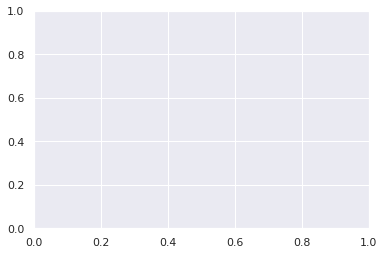

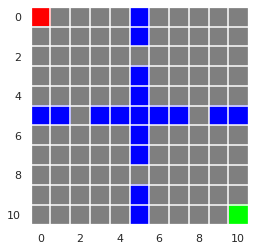

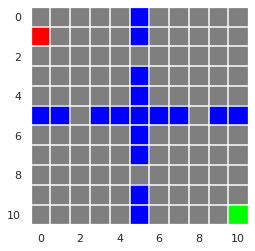

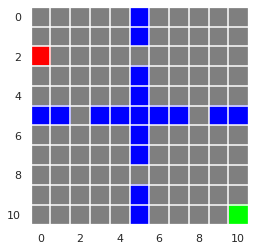

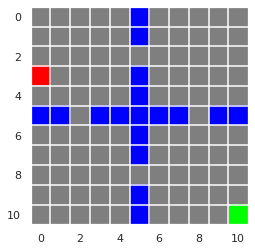

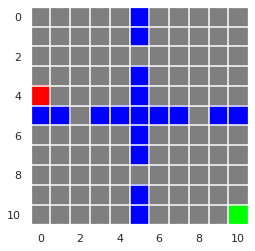

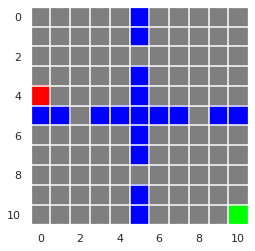

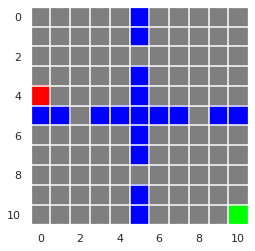

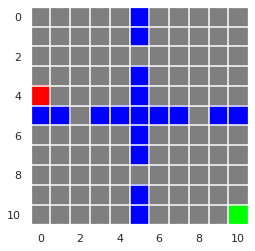

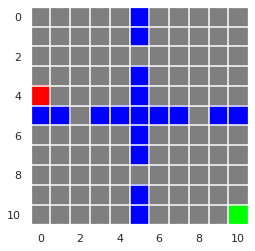

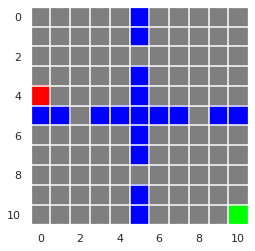

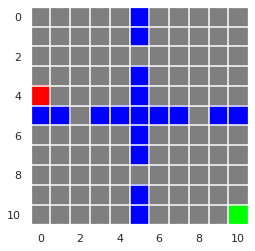

In [12]:
# latent_dimension = int(env._state_dim / 1.2)
latent_dimension = 100
hidden_ratio = 2.
param_agent = {
    "gamma": 0.90,
    "optimizer_LSFM": keras.optimizers.Adam(),
    "optimizer_Q": keras.optimizers.Adam(),
    "alpha_r" : 1.,
    "alpha_N" : 0.1,
    "alpha_psi" : 0.01,
    "alpha_phi" : 0.01,
    "policy": {
        "type": ["eps-greedy", "exponantial"],
        "eps-greedy": {
            "exponantial": {
                "eps_max": 1.,
                "eps_min": 0.01,
                "lambda": 0.002
            },
            "constant": {
                "eps": 0.01
            }
        }
    },
    "memory" : 500000,
    "latent_space": latent_dimension,
    "hidden_dim_ratio": hidden_ratio,
    "num_episodes" : 100,
    "batch_size" : 32,
    "double_model" : True,
    "tau": 0.08,
    "filter_done" : True,
    "train_LSFM" : True,
    "train_on_Q_latent": True,
    "model_Q_Lin": True,
    "train" : True,
    "RANDOM_REWARD_STD" : -1.0, 
    "reward_parser" : [-1.5,-0.5,0.5,1.5],
    "eigenoption_number" : 8,
    "eigen_exploitation" : 0.5,
    "discoverNegation" : True,
    "render" : False,
}

agent = Agent(env, param_agent)


state = env.reset()
env.render()
actions_down = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
for i in range(10) : 
    action = actions_down[i]
    next_state, reward, done, info = env.step(action)

    print("action", action)
    print(" 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right")
#     print("next_state", next_state)
    print("reward", reward)
    print("done", done)
    env.render()
    
    state = next_state



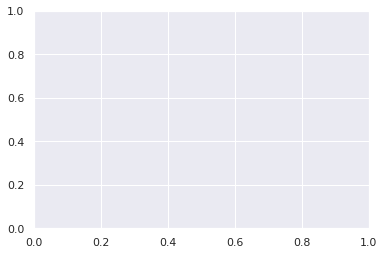

In [13]:
agent = Agent(env, param_agent)

In [14]:

from tensorflow.keras.models import load_model
from tensorflow.keras.models import save_model

agent.model_LSFM.save_weights(folder_WORK+"/agent_LSFM_model")
agent.model_LSFM.load_weights(folder_WORK+"/agent_LSFM_model")
# model.load_weights("savedmodel.hdf5")

# save_model(agent.model_LSFM, folder_WORK+"/agent_LSFM_model")

In [15]:
def random_action(env) : 
    return random.randint(0, env.action_space.n - 1)

# models summary

## LSFM

Model: "model_LSFM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_state (InputLayer)        [(None, 121)]        0                                            
__________________________________________________________________________________________________
hidden_latent (Dense)           (None, 200)          24400       input_state[0][0]                
__________________________________________________________________________________________________
latent (Dense)                  (None, 100)          20100       hidden_latent[0][0]              
__________________________________________________________________________________________________
ra (Dense)                      (None, 24)           2400        latent[0][0]                     
_________________________________________________________________________________________

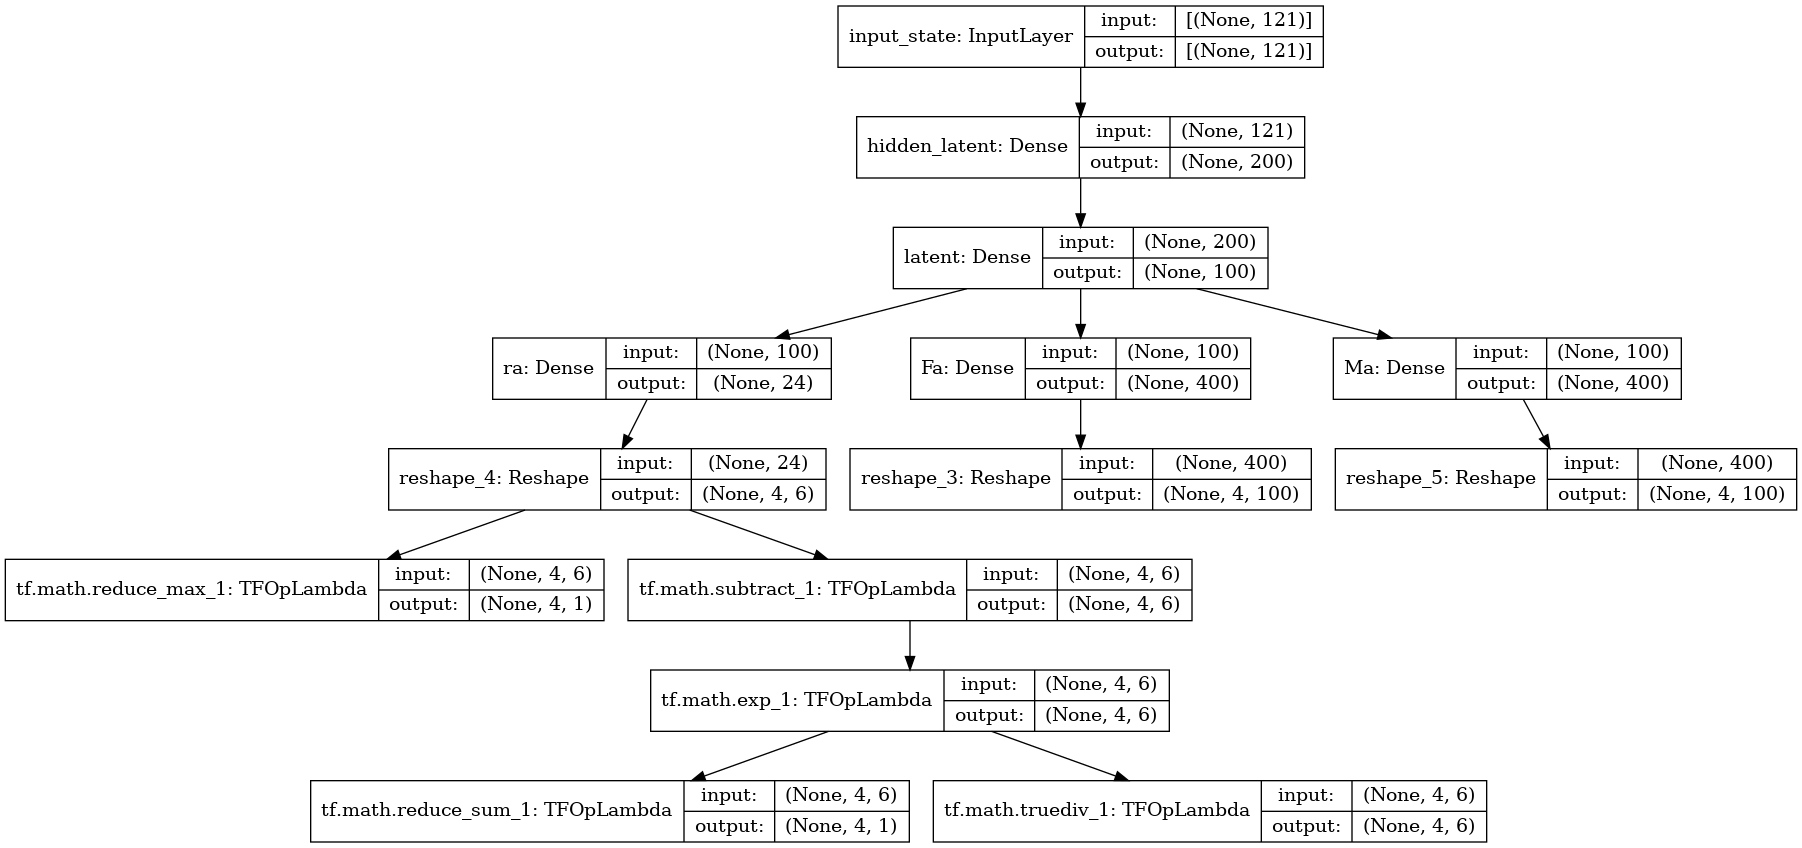

In [16]:
agent.model_LSFM.summary()
keras.utils.plot_model(agent.model_LSFM, "my_first_model.png", show_shapes=True)

In [17]:
for layer in agent.model_LSFM.layers:
    print(layer.name, type(layer.output_shape), len(layer.output_shape),layer.output_shape[-1] )
    

input_state <class 'list'> 1 (None, 121)
hidden_latent <class 'tuple'> 2 200
latent <class 'tuple'> 2 100
ra <class 'tuple'> 2 24
reshape_4 <class 'tuple'> 3 6
tf.math.reduce_max_1 <class 'tuple'> 3 1
tf.math.subtract_1 <class 'tuple'> 3 6
tf.math.exp_1 <class 'tuple'> 3 6
Fa <class 'tuple'> 2 400
Ma <class 'tuple'> 2 400
tf.math.reduce_sum_1 <class 'tuple'> 3 1
reshape_3 <class 'tuple'> 3 100
reshape_5 <class 'tuple'> 3 100
tf.math.truediv_1 <class 'tuple'> 3 6


## Linear QLearning
Qlearning on latent space

### QLin on latent space

Agent_Q.model : initialization model_Q_Lin
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, 4)                   400       
Total params: 400
Trainable params: 400
Non-trainable params: 0
_________________________________________________________________


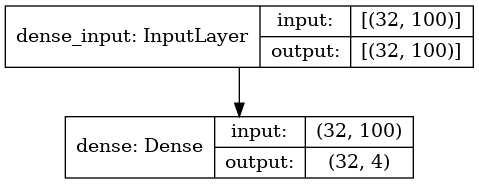

In [18]:
param_agent["model_Q_Lin"] = True

x= np.zeros((param_agent["batch_size"],param_agent["latent_space"]), dtype=float)

agent_Q = Agent_Q(env, param_agent)
agent_Q.model(x)

agent_Q.model.summary()
keras.utils.plot_model(agent_Q.model, "my_first_model_Q.png", show_shapes=True)

### DQN on original space

Agent_Q.model : initialization model_DQN
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent (Dense)               (32, 100)                 12200     
_________________________________________________________________
dense_1 (Dense)              (32, 4)                   404       
Total params: 12,604
Trainable params: 12,604
Non-trainable params: 0
_________________________________________________________________


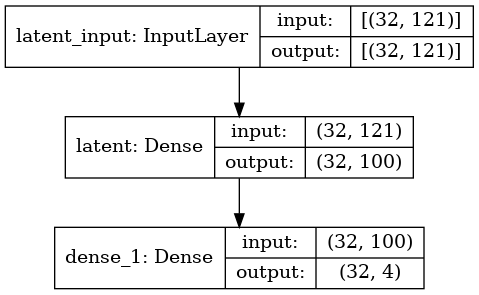

In [19]:
param_agent["model_Q_Lin"] = False

x= np.zeros((param_agent["batch_size"],env._state_dim), dtype=float)

agent_Q = Agent_Q(env, param_agent)
agent_Q.model(x)

agent_Q.model.summary()
keras.utils.plot_model(agent_Q.model, "my_first_model_Q.png", show_shapes=True)

# Function

## environments

### first (puddle word)

memory clean 0
memory clean 1000
memory clean 2000
memory clean 3000
memory clean 4000
memory clean 5000
memory clean 6000
memory clean 7000
memory clean 8000
memory clean 9000
memory clean 10000
memory clean 11000
memory clean 12000
memory clean 13000
memory clean 14000
memory clean 15000
memory clean 16000
memory clean 17000
memory clean 18000
memory clean 19000
memory clean 20000
memory clean 21000
memory clean 22000
memory clean 23000
memory clean 24000
memory clean 25000
memory clean 26000
memory clean 27000
memory clean 28000
memory clean 29000
memory clean 30000
memory clean 31000
memory clean 32000
memory clean 33000
memory clean 34000
memory clean 35000
memory clean 36000
memory clean 37000
memory clean 38000
memory clean 39000
memory clean 40000
memory clean 41000
memory clean 42000
memory clean 43000
memory clean 44000
memory clean 45000
memory clean 46000
memory clean 47000
memory clean 48000
memory clean 49000
satet [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

<ipython-input-4-ef59c99ffdcd>:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


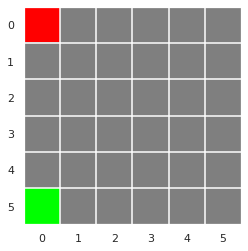

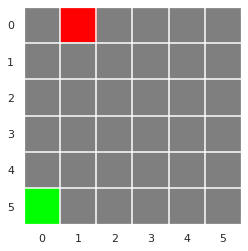

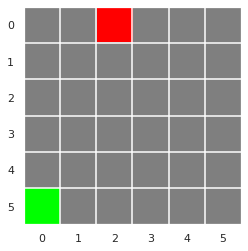

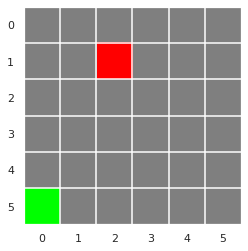

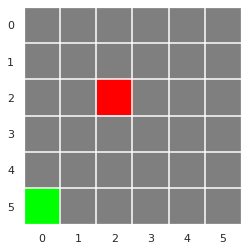

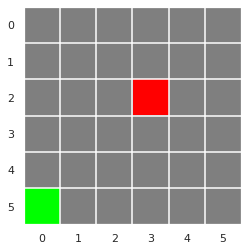

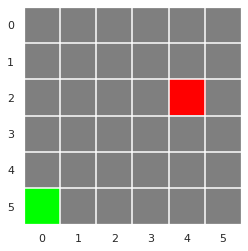

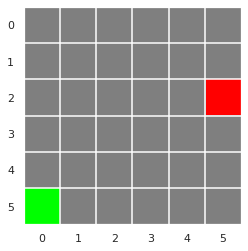

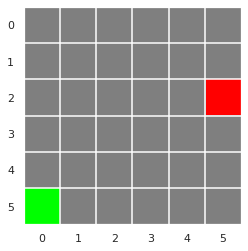

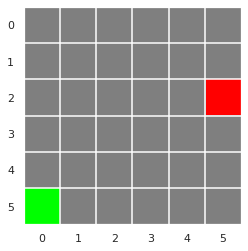

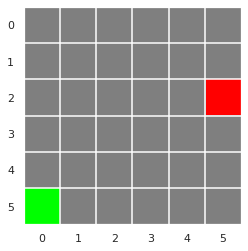

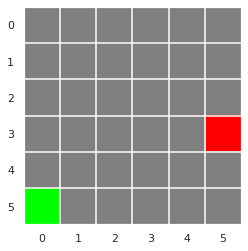

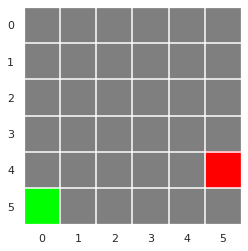

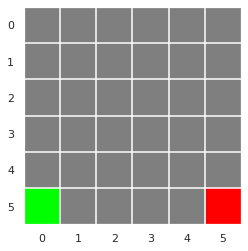

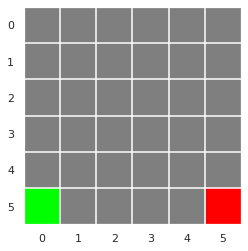

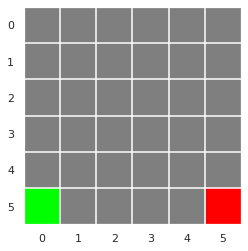

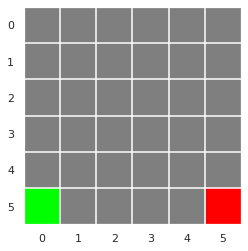

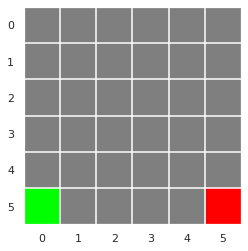

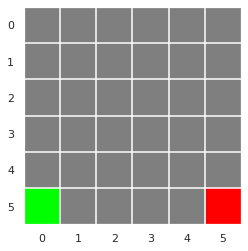

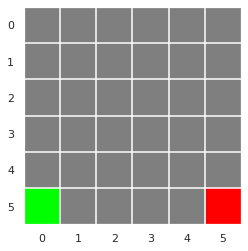

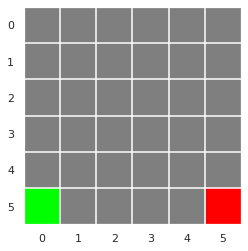

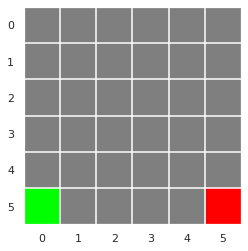

In [20]:


def clean_duplicate(memory) : 

    df = pd.DataFrame(memory._samples)
    df[5] = df[5].astype(np.float32)

    col_st = [ "st_"+str(k) for k in range(len(df[0][0]))]
    col_ma= [ "ma_"+str(k) for k in range(len(df[1][0]))]
    col_nst = [ "nst_"+str(k) for k in range(len(df[4][0]))]

    col_st, col_nst
    st_exp = pd.DataFrame(df[0].to_list(), columns = col_st)
    ma_exp = pd.DataFrame(df[1].to_list(), columns = col_ma)
    nst_exp = pd.DataFrame(df[4].to_list(), columns = col_nst)

    exp = pd.concat([st_exp,ma_exp,df.loc[:, [2,3]], nst_exp, df[5]], axis=1)
    keep_id = list(exp.drop_duplicates().index)

    memory_clean = memory
    memory_clean._samples = [memory_clean._samples[i] for i in keep_id]
    
    return memory_clean
    
# param_env = {
#     "agent_pos":[0, 0], 
#     "goal_pos":[[10,0] ],
#     "reward_minmax":[-1.,-0.001],
#     "reward_user_defined":True,
#     "reward_pos":[
#         [0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[0, 6],[0, 7],[0, 8],[0, 9],[0, 10],
#         [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[1, 6],[1, 7],[1, 8],[1, 9],[1, 10],
#                                                                 [2, 8],[2, 9],[2, 10],
#                                                                 [3, 8],[3, 9],[3, 10],
#                                                                 [4, 8],[4, 9],[4, 10],
#                                                                 [5, 8],[5, 9],[5, 10],
#                                                                 [6, 8],[6, 9],[6, 10],
#                                                                 [7, 8],[7, 9],[7, 10],
#                                                                 [8, 8],[8, 9],[8, 10],
#         [9, 0],[9, 1],[9, 2],[9, 3],[9, 4],[9, 5],[9, 6],[9, 7],[9, 8],[9, 9],[9, 10],
#         [10,0],[10,1],[10,2],[10,3],[10,4],[10,5],[10,6],[10,7],[10,8],[10,9],[10,10]
#                 ],
#     "grid_size" : 11,
#     "pattern": "empty",
#     "obs_mode":"index",
# }



# param_env = {
#     "agent_pos":[0, 0], 
#     "goal_pos":[[5,0] ],
#     "reward_minmax":[-1.,0.],
#     "reward_user_defined":True,
#     "reward_pos":[[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5], 
#                   [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5], 
#                                               [2, 4],[2, 5], 
#                                               [3, 4],[3, 5], 
#                   [4, 0],[4, 1],[4, 2],[4, 3],[4, 4],[4, 5], 
#                   [5, 0],[5, 1],[5, 2],[5, 3],[5, 4],[5, 5]],
#     "grid_size" : 6,
#     "pattern": "empty",
#     "obs_mode":"index",
# }


param_env = {
    "agent_pos":[0, 0], 
    "goal_pos":[[5,0] ],
    "reward_pos": [[5,0] ],
    "grid_size" : 6,
    "reward_minmax":[0.,0.],
    "reward_user_defined":False,
    "pattern":"empty",
    "obs_mode":"index",
}


env_name = "SimpleGrid"
env = custom_env(env_name, param_env)
environment = env


data = pd.DataFrame()
state = environment.reset()

nb_transi = 50000

action_no_mask = [1,1,1,1]
memory = Memory(param_agent["memory"])

for k in range(nb_transi) : 

    action, eps = agent.choose_action_random()
    next_state, reward, done, info = environment.step(action)

    
#     memory = add_in_memory(state, action_no_mask, action, reward, next_state, done, memory) 
    memory.add_sample((state, action_no_mask, action, reward, next_state, done))
    
    if k%1000 == 0 : 
        memory = clean_duplicate(memory)
        print("memory clean", k)
    
    state = next_state
    
    if done : 
        state = environment.reset()
     

memory = clean_duplicate(memory)
memory.write("memory_simple.csv")

















state = env.reset()
actions_down = [3,3,1,1,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,3,3,3,3,3]

for i in range(22) : 
    env.render()
    action = actions_down[i]
    next_state, reward, done, info = env.step(action)

    print("satet", state)
    print("action", action)
    print(" 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right")
#     print("next_state", next_state)
    print("reward", reward)
    print("done", done)
    
    state = next_state


### second (four room)

memory clean 0
memory clean 4000
memory clean 8000
memory clean 12000
memory clean 16000
memory clean 20000
memory clean 24000
memory clean 28000
memory clean 32000
memory clean 36000
memory clean 40000
memory clean 44000
memory clean 48000
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
r

<ipython-input-4-ef59c99ffdcd>:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


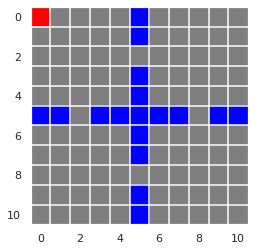

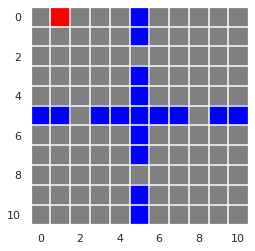

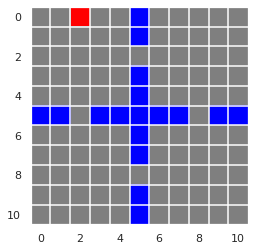

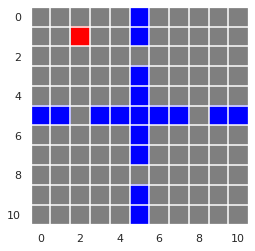

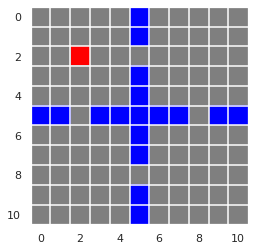

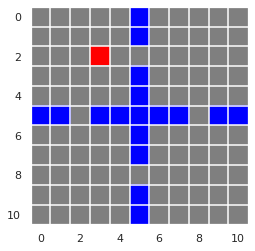

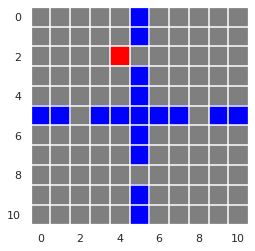

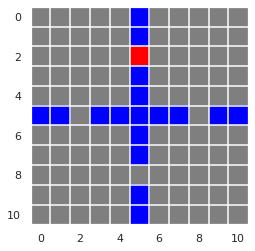

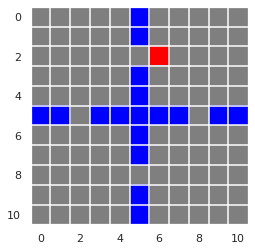

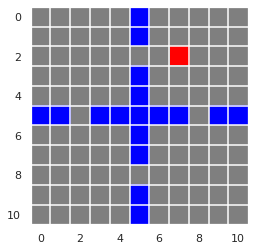

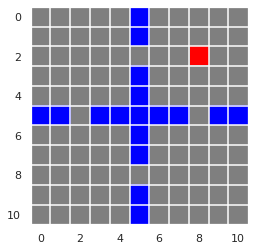

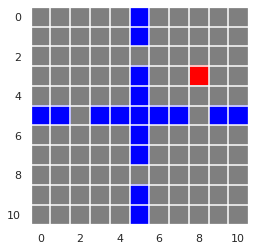

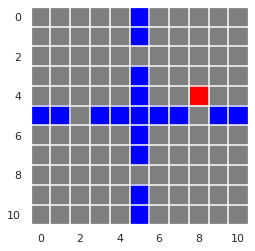

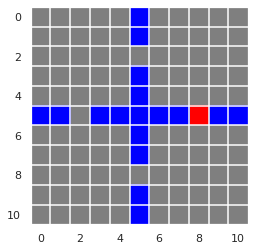

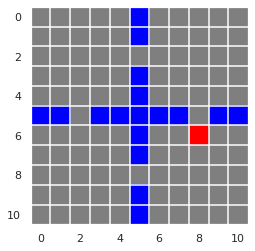

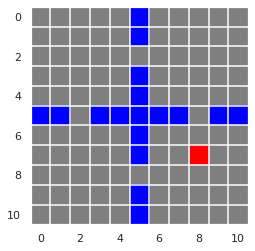

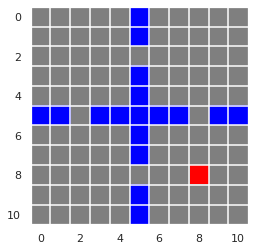

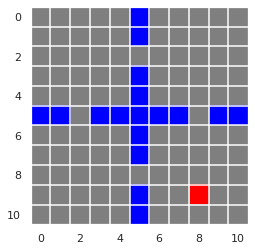

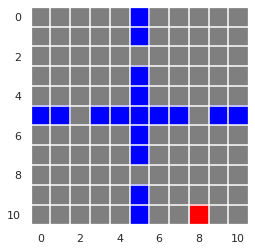

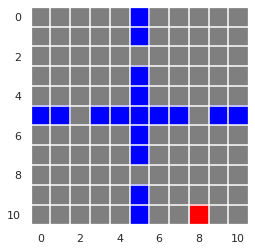

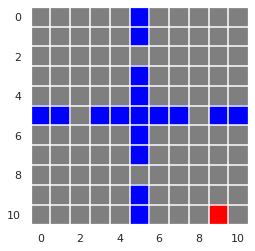

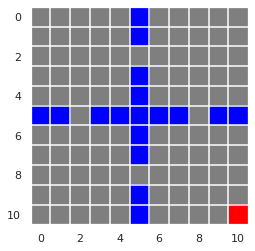

In [21]:
# param_env = {
#     "agent_pos":[0, 0], 
#     "goal_pos":[[10,10] ],
#     "reward_minmax":[0.,0.],
#     "reward_user_defined":False,
#     "reward_pos":None,
#     "grid_size" : 11,
#     "pattern": "four_rooms",
#     "obs_mode":"index",
# }

param_env = {
    "agent_pos":[0, 0], 
    "goal_pos":[],
    "reward_minmax":[0.,0.],
    "reward_user_defined":False,
    "reward_pos":[],
    "grid_size" : 11,
    "pattern": "four_rooms",
    "obs_mode":"index",
}



env_name = "SimpleGrid"
env_change_reward = custom_env(env_name, param_env)
environment = env_change_reward


data = pd.DataFrame()
state = environment.reset()

nb_transi = 50000

action_no_mask = [1,1,1,1]
memory = Memory(param_agent["memory"])

for k in range(nb_transi) : 

    action, eps = agent.choose_action_random()
    next_state, reward, done, info = environment.step(action)

    
    memory.add_sample((state, action_no_mask, action, reward, next_state, done))
    
    
    if k%4000 == 0 : 
        memory = clean_duplicate(memory)
        print("memory clean", k)
    
    state = next_state
    
    if done : 
        state = environment.reset()
     


memory.write("memory_env_change_reward.csv")



state = env_change_reward.reset()
actions_down = [3,3,1,1,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,3,3,3,3,3]
for i in range(22) : 
    env_change_reward.render()
    action = actions_down[i]
    next_state, reward, done, info = env_change_reward.step(action)

    print("action", action)
    print(" 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right")
#     print("next_state", next_state)
    print("reward", reward)
    print("done", done)
    
    state = next_state

### Load Buffer

/home/ious/miniconda3/envs/gym/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ious/miniconda3/envs/gym/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/ious/miniconda3/envs/gym/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ious/miniconda3/envs/gym/lib/python3.8/site-packages/seaborn/dist

[Text(0.5, 1.0, 'Reward distribution on at the end of episode')]

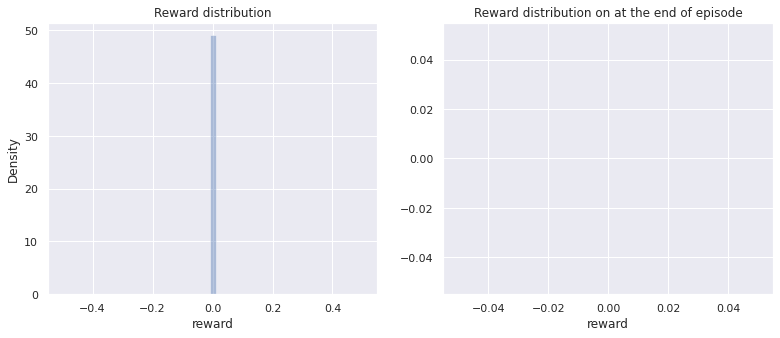

In [22]:

# **********************************************
# **********************************************
df = pd.read_csv("memory_env_change_reward.csv")
# **********************************************
# **********************************************



df["observation"] = df["observation"].apply(eval)
df["action_mask"] = df["action_mask"].apply(eval)
df["new_observation"] = df["new_observation"].apply(eval)

buff_df = df

Ends = buff_df.loc[buff_df["finished"]==True]

if len(Ends) >0 : 
    nb_ep = len(Ends)
    nb_Ep_train = int(nb_ep*0.8)
    nb_Ep_test = nb_ep - nb_Ep_train
    
    id_train = buff_df.loc[buff_df["finished"]==True].iloc[nb_Ep_train].name
else : 
    nb_Ep_train = int(len(df)*0.8)
    nb_Ep_test = int(len(df)) - nb_Ep_train
    
    id_train = nb_Ep_train


buffer_train = list(buff_df.loc[0:id_train].values)
buffer_test = list(buff_df.loc[id_train+1:].values)

fig, axs = plt.subplots(1,2, figsize=(13, 5))

sns.distplot(buff_df['reward'], ax = axs[0]).set(title='Reward distribution')
sns.distplot(Ends['reward'], ax = axs[1]).set(title='Reward distribution on at the end of episode')


# sns.barplot(x="error", y="MSE", hue="action", data=reward_positive, ax = axs[0]).set(
#     title='Test errors on positive rewards (>{}) by actions'.format(thresold))

# sns.barplot(x="error", y="MSE", data=global_losses, ax = axs[1]).set(title='Test global errors')


# plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
# plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')











## functions simulations

In [23]:
def experience_random_collection(env, param_agent, buffer = None) : 
    
    
    data = pd.DataFrame()
    state = env.reset()
    
    for k in range(param_agent["run"]) : 
                
        action, eps = agent_LSFM.choose_action_random()
        next_state, reward, done, info = env.step(action)
            
            
            
            
        
        result_compile, agent_LSFM, memory = simu_online_LSFM(env,param_agent, buffer=None)
    
        memory.write("memory.csv")
        data_train_df = pd.DataFrame(result_compile, columns=[ 
        "Episode", 
        "Step", 
        "cum_step",
        "Reward", 
        "Reward_cum",
        "Eps",  
        "Avg_loss" ,  
        "Avg_loss_r",  
        "Avg_loss_N",  
        "Avg_loss_psi", "Avg_loss_phi"])

        data_train_df["carac"] = carac_model(param_agent) 
        data_train_df["run"] = k
        data = pd.concat([data, data_train_df])

    return data, agent_LSFM

### Offline

In [24]:
def simu_offline_LSFM(env,param_agent, buffer) : 
    
    result_compile = []
    steps = 0

#     No mask for simple env
    if env.env_name == "SimpleGrid" : 
        action_space = np.arange(env.action_space.n)
        action_no_mask = np.full((env.action_space.n), 1)   
        possible_action = action_space

    memory = Memory(param_agent["memory"], buffer)

    avg_loss = 0
    avg_loss_r  = 0
    avg_loss_N  = 0
    avg_loss_psi  = 0

    agent_LSFM = Agent(env, param_agent)
    model_LSFM = agent_LSFM.model_LSFM
    
    

    for i in range(param_agent["num_steps"]):

        avg_loss = 0

#         TRAIN ON BUFFER ONLY 
        if buffer != None : 

            loss_all = agent_LSFM.train_LSFM(
                        model_LSFM, 
                        memory, 
                        param_agent["filter_done"])
            
            avg_loss += loss_all[0]
            avg_loss_r += loss_all[1]
            avg_loss_N += loss_all[2]
            avg_loss_psi += loss_all[3]


            if steps>0 : 
                if steps % 200 == 0:
                    avg_loss /= steps
                    avg_loss_r /= steps
                    avg_loss_N /= steps
                    avg_loss_psi /= steps
#                     loss_phisp1 /= steps

                    result = [steps, avg_loss, avg_loss_r, avg_loss_N, avg_loss_psi]
    
                    print("cumul_step: {:06d}, L: {:0.4f}, Lr: {:0.4f}, LN: {:0.4f}, Lpsi: {:0.4f}".format(*result[:]))

                    result_compile.append(result)

            steps += 1

    return result_compile, agent_LSFM, memory
       
    
    
    


def experience_offline_LSFM(env,param_agent,buffer) : 
    
    data = pd.DataFrame()
    
    for k in range(param_agent["run"]) : 
    
        result_compile, agent_LSFM, memory = simu_offline_LSFM(env,param_agent, buffer)
    
        memory.write("memory.csv")
        data_train_df = pd.DataFrame(result_compile, columns=[ 
        "cum_step",
        "Avg_loss" ,  
        "Avg_loss_r",  
        "Avg_loss_N",  
        "Avg_loss_psi"])

        data_train_df["carac"] = carac_model(param_agent) 
        data_train_df["run"] = k
        data = pd.concat([data, data_train_df])
        
        
    return data, agent_LSFM

### Test error on datatest

In [25]:
def test_error_Ma_rewClassif_offline_LSFM(env,param_agent, buffer, save_model_path, reward_parser) : 
    
    result_compile = []
    steps = 0

#     No mask for simple env
    if env.env_name == "SimpleGrid" : 
        action_space = np.arange(env.action_space.n)
        action_no_mask = np.full((env.action_space.n), 1)   
        possible_action = action_space

    memory = Memory(param_agent["memory"], buffer)

    avg_loss = 0
    avg_loss_r  = 0
    avg_loss_N  = 0
    avg_loss_psi  = 0

    agent_LSFM = Agent(env, param_agent, save_model_path)
    model_LSFM = agent_LSFM.model_LSFM

    y_true_compile = []
    y_pred_compile = []

    for i in range(param_agent["num_episodes"]):
        
        cnt = 0
        
        state,*_= buffer[steps]
        
        states = np.array(state).reshape(1,-1)
        phi_pred = model_LSFM(states)["phi"]
        
        while True:

            avg_loss = 0

            state, action_mask, action, reward, next_state, done = buffer[steps]
            
            states = np.array(state).reshape(1,-1)
            action_masks = np.array(action_mask).reshape(1,-1)
            actions = [action]
            rewards = [reward]
            next_states = np.array(next_state).reshape(1,-1)
            terminates = [done]
            
            
            target_psi = agent_LSFM.target_psi(
                model_LSFM, states, actions, next_states,terminates,rewards, param_agent["filter_done"])

#             loss_tot, loss_r ,  loss_N , loss_psi , loss_phi = agent_LSFM.losses_all(
#                 states, actions, rewards,next_states, target_psi, agent_LSFM)
            
            
            phi = model_LSFM(states)["phi"]
            phi_sp1 = agent_LSFM.model_LSFM(next_states)["phi"]
#             next_state_latent = np.array(tf.reshape(phi_sp1, phi_sp1.shape[-1]))


#             y_true = [reward, 1., target_psi, next_state_latent]

            logits_r = agent_LSFM.get_from_actions( states, actions, model_LSFM, "ra")
            reward_onestep = tf.keras.backend.get_value(logits_r)[0]
#             reward_onestep = tf.keras.backend.get_value(logits_r)[0]
            
            norm_phi = tf.keras.backend.get_value(tf.norm(phi, axis=1))[0]
            
            logits_psi = agent_LSFM.get_from_actions( states, actions, model_LSFM, "Fa")
            phi_sp1_pred = agent_LSFM.get_from_actions( states, actions, model_LSFM, "Ma") 

            reward_n_step = tf.keras.backend.get_value(
                agent_LSFM.next_rewards( phi_pred, actions, model_LSFM))[0]

            
            
            y_true = [i, cnt, steps,  done, action, discretize(reward, reward_parser),
                      1., target_psi,   phi_sp1, discretize(reward, reward_parser)]
            
            
            
            y_pred = [i, cnt, steps,  done, action, reward_onestep,
                      norm_phi, logits_psi, phi_sp1_pred, reward_n_step]
            
            y_true_compile.append(y_true)
            y_pred_compile.append(y_pred)
            
            
            
            
            phi_pred = phi_sp1_pred
            
            
            steps += 1
            
            if done:

#                 if cnt != 0:
#                     avg_loss /= cnt
#                     avg_loss_r /= cnt
#                     avg_loss_N /= cnt
#                     avg_loss_psi /= cnt
#                     loss_phip1 /= cnt

#                 else:
#                     avg_loss = 0
#                     loss_phip1 = 0

               
    
                if i % 1  == 0 : 
                    print(
                    "Ep: {:03d}, stEp: {:03d}, stAll: {:04d}".format(*y_true[:]))

#                 y_true_compile.append(y_true)
#                 y_pred_compile.append(y_true)
    #             with train_writer.as_default():
    #                 tf.summary.scalar('reward', cnt, step=i)
    #                 tf.summary.scalar('avg loss', avg_loss, step=i)
                break

            cnt += 1
            
    y_true_df = pd.DataFrame(y_true_compile, columns=[ 
    "Ep",
    "stEp" ,  
    "stAll",
    "finished",
    "action",
    "reward_one-step",  
    "Norm_phi", 
    "target_psi",
    "phi_sp1",
    "reward_n-step"])
    y_pred_df = pd.DataFrame(y_pred_compile, columns=[ 
    "Ep",
    "stEp" ,  
    "stAll",
    "finished",
    "action",
    "reward_one-step",  
    "Norm_phi", 
    "target_psi",
    "phi_sp1",
    "reward_n-step"])
        


    return y_pred_df, y_true_df
       
    
    

In [26]:
def test_error_Ma_offline_LSFM(env,param_agent, buffer, save_model_path) : 
    
    result_compile = []
    steps = 0

#     No mask for simple env
    if env.env_name == "SimpleGrid" : 
        action_space = np.arange(env.action_space.n)
        action_no_mask = np.full((env.action_space.n), 1)   
        possible_action = action_space

    memory = Memory(param_agent["memory"], buffer)

    avg_loss = 0
    avg_loss_r  = 0
    avg_loss_N  = 0
    avg_loss_psi  = 0

    agent_LSFM = Agent(env, param_agent, save_model_path)
    model_LSFM = agent_LSFM.model_LSFM

    y_true_compile = []
    y_pred_compile = []

    for i in range(param_agent["num_episodes"]):
        
        cnt = 0
        
        state,*_= buffer[steps]
        
        states = np.array(state).reshape(1,-1)
        phi_pred = model_LSFM(states)["phi"]
        
        while True:

            avg_loss = 0

            state, action_mask, action, reward, next_state, done = buffer[steps]
            
            states = np.array(state).reshape(1,-1)
            action_masks = np.array(action_mask).reshape(1,-1)
            actions = [action]
            rewards = [reward]
            next_states = np.array(next_state).reshape(1,-1)
            terminates = [done]
            
            
            phi = model_LSFM(states)["phi"]
            phi_sp1 = agent_LSFM.model_LSFM(next_states)["phi"]
#             next_state_latent = np.array(tf.reshape(phi_sp1, phi_sp1.shape[-1]))


            target_psi = agent_LSFM.target_psi(model_LSFM, states, actions, next_states,terminates,rewards, param_agent["filter_done"])

#             y_true = [reward, 1., target_psi, next_state_latent]

            logits_r = agent_LSFM.get_from_actions( states, actions, model_LSFM, "ra")
            reward_onestep = tf.keras.backend.get_value(logits_r)[0]
            
            norm_phi = tf.keras.backend.get_value(tf.norm(phi, axis=1))[0]
            
            logits_psi = agent_LSFM.get_from_actions( states, actions, model_LSFM, "Fa")
            phi_sp1_pred = agent_LSFM.get_from_actions( states, actions, model_LSFM, "Ma") 

            reward_n_step = tf.keras.backend.get_value(
                agent_LSFM.next_rewards( phi_pred, actions, model_LSFM)[0]
            )


            
            y_true = [i, cnt, steps,  done, action, reward,
                      1., target_psi,   phi_sp1, reward]
            y_pred = [i, cnt, steps,  done, action, reward_onestep,
                      norm_phi, logits_psi, phi_sp1_pred, reward_n_step]
            
            y_true_compile.append(y_true)
            y_pred_compile.append(y_pred)
            
            
            
            
            
            phi_pred = phi_sp1_pred
            steps += 1
            
            if done:

#                 if cnt != 0:
#                     avg_loss /= cnt
#                     avg_loss_r /= cnt
#                     avg_loss_N /= cnt
#                     avg_loss_psi /= cnt
#                     loss_phip1 /= cnt

#                 else:
#                     avg_loss = 0
#                     loss_phip1 = 0

               
    
                if i % 1  == 0 : 
                    print(
                    "Ep: {:03d}, stEp: {:03d}, stAll: {:04d}".format(*y_true[:]))

#                 y_true_compile.append(y_true)
#                 y_pred_compile.append(y_true)
    #             with train_writer.as_default():
    #                 tf.summary.scalar('reward', cnt, step=i)
    #                 tf.summary.scalar('avg loss', avg_loss, step=i)
                break

            cnt += 1
            
    y_true_df = pd.DataFrame(y_true_compile, columns=[ 
    "Ep",
    "stEp" ,  
    "stAll",
    "finished",
    "action",
    "reward_one-step",  
    "Norm_phi", 
    "target_psi",
    "phi_sp1",
    "reward_n-step"])
    y_pred_df = pd.DataFrame(y_pred_compile, columns=[ 
    "Ep",
    "stEp" ,  
    "stAll",
    "finished",
    "action",
    "reward_one-step",  
    "Norm_phi", 
    "target_psi",
    "phi_sp1",
    "reward_n-step"])
        


    return y_pred_df, y_true_df
       
    
    

In [27]:
def test_error_offline_LSFM(env,param_agent, buffer, save_model_path) : 
    
    result_compile = []
    steps = 0

#     No mask for simple env
    if env.env_name == "SimpleGrid" : 
        action_space = np.arange(env.action_space.n)
        action_no_mask = np.full((env.action_space.n), 1)   
        possible_action = action_space

    memory = Memory(param_agent["memory"], buffer)

    avg_loss = 0
    avg_loss_r  = 0
    avg_loss_N  = 0
    avg_loss_psi  = 0

    agent_LSFM = Agent(env, param_agent, save_model_path)
    model_LSFM = agent_LSFM.model_LSFM
    
    agent_LSFM.M_transi(model_LSFM)
    
#     nb_steps = min(param_agent["num_steps"], len(buffer))
#     trajectories = []
#     trajectory = []

    y_true_compile = []
    y_pred_compile = []

    for i in range(param_agent["num_episodes"]):
        
        cnt = 0
        
        state,*_= buffer[steps]
        
        states = np.array(state).reshape(1,-1)
        phi_pred = model_LSFM(states)["phi"]
        
        while True:

            avg_loss = 0

            state, action_mask, action, reward, next_state, done = buffer[steps]
            
            states = np.array(state).reshape(1,-1)
            action_masks = np.array(action_mask).reshape(1,-1)
            actions = [action]
            rewards = [reward]
            next_states = np.array(next_state).reshape(1,-1)
            terminates = [done]
            
            
            phi = model_LSFM(states)["phi"]
            phi_sp1 = agent_LSFM.model_LSFM(next_states)["phi"]
#             next_state_latent = np.array(tf.reshape(phi_sp1, phi_sp1.shape[-1]))


            target_psi = agent_LSFM.target_psi(model_LSFM, states, actions, next_states,terminates,rewards, param_agent["filter_done"])

#             y_true = [reward, 1., target_psi, next_state_latent]

            logits_r = agent_LSFM.get_from_actions( states, actions, model_LSFM, "ra")
            reward_onestep = tf.keras.backend.get_value(logits_r)[0]
            
            norm_phi = tf.keras.backend.get_value(tf.norm(phi, axis=1))[0]
            
            logits_psi = agent_LSFM.get_from_actions( states, actions, model_LSFM, "Fa")
            phi_sp1_pred = agent_LSFM.next_phi_pred(model_LSFM, phi_pred,actions)
#             y_pred = [logits_r, tf.norm(y_pred, axis=1), logits_psi, phi_sp1]



            reward_n_step = tf.keras.backend.get_value(
                agent_LSFM.next_rewards( phi_pred, actions, model_LSFM)[0]
            )


            
            y_true = [i, cnt, steps,  done, action, reward,                      1., target_psi,   phi_sp1, reward]
            y_pred = [i, cnt, steps,  done, action, reward_onestep, norm_phi, logits_psi, phi_sp1_pred, reward_n_step]
            
            y_true_compile.append(y_true)
            y_pred_compile.append(y_pred)
            
            
            
            
            
            phi_pred = phi_sp1_pred
            steps += 1
            
            if done:

#                 if cnt != 0:
#                     avg_loss /= cnt
#                     avg_loss_r /= cnt
#                     avg_loss_N /= cnt
#                     avg_loss_psi /= cnt
#                     loss_phip1 /= cnt

#                 else:
#                     avg_loss = 0
#                     loss_phip1 = 0

               
    
                if i % 1  == 0 : 
                    print(
                    "Ep: {:03d}, stEp: {:03d}, stAll: {:04d}".format(*y_true[:]))

#                 y_true_compile.append(y_true)
#                 y_pred_compile.append(y_true)
    #             with train_writer.as_default():
    #                 tf.summary.scalar('reward', cnt, step=i)
    #                 tf.summary.scalar('avg loss', avg_loss, step=i)
                break

            cnt += 1
            
    y_true_df = pd.DataFrame(y_true_compile, columns=[ 
    "Ep",
    "stEp" ,  
    "stAll",
    "finished",
    "action",
    "reward_one-step",  
    "Norm_phi", 
    "target_psi",
    "phi_sp1",
    "reward_n-step"])
    y_pred_df = pd.DataFrame(y_pred_compile, columns=[ 
    "Ep",
    "stEp" ,  
    "stAll",
    "finished",
    "action",
    "reward_one-step",  
    "Norm_phi", 
    "target_psi",
    "phi_sp1",
    "reward_n-step"])
        


    return y_pred_df, y_true_df
       
    
    

### Old simus

In [28]:
def simu(env,param_agent,agent_LSFM = None, agent_Q = None) : 
    
    
    result_compile = []

    steps = 0
    render = param_agent["render"]

    reward_cumul = 0

#     action_space = np.arange(env.action_space.n)
#     possible_action = action_space
    
    
#     No mask for simple env
    if env.env_name == "SimpleGrid" : 
        action_space = np.arange(env.action_space.n)
        action_no_mask = np.full((env.action_space.n), 1)   
        possible_action = action_space

    
    memory = Memory(param_agent["memory"])
    memory_latent = Memory(param_agent["memory"])

    
    avg_loss = 0
    avg_loss_r  = 0
    avg_loss_N  = 0
    avg_loss_psi  = 0
    
    if agent_LSFM!= None : model_LSFM = agent_LSFM.model_LSFM
        
#     model_LSFM_prev= agent_LSFM.model_LSFM_prev
    if param_agent["train_LSFM"] == False : 
        model_Q = agent_Q.model
        model_Q_prev = agent_Q.model_prev
    
    for i in range(param_agent["num_episodes"]):
        state = env.reset()

        reward_ep_cumul = 0
        cnt = 0
        avg_loss = 0
        while True:
            if render:
                env.render()

            if param_agent["train_LSFM"] : 
                action, eps = agent_LSFM.choose_action_random()
                next_state, reward, done, info = env.step(action)
            else : 
                if param_agent["train_on_Q_latent"] : 
                    
                    state_resh = state.reshape(1,-1)
                    phi = agent_LSFM.model_LSFM(state_resh)["phi"]
                    state_latent = np.array(tf.reshape(phi, phi.shape[-1]))

                    # eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * steps)
                                        
                    action, eps = agent_Q.choose_action(
                                        state_latent, 
                                        model_Q, 
                                        steps, 
                                        possible_action
                                    )
                    
                    next_state, reward, done, info = env.step(action)

                    next_state_resh = next_state.reshape(1,-1)
                    phi_prime = agent_LSFM.model_LSFM(next_state_resh)["phi"]
                    next_state_latent = np.array(tf.reshape(phi_prime, phi_prime.shape[-1]))

                    
                else : 
                # eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * steps)
                    action, eps = agent_Q.choose_action(
                        state, 
                        model_Q, 
                        steps, 
                        possible_action
                    )

                    next_state, reward, done, info = env.step(action)


            if param_agent["RANDOM_REWARD_STD"] > 0:
                reward = np.random.normal(1.0, RANDOM_REWARD_STD)

            reward_ep_cumul += reward
            reward_cumul += reward
            
            if done:
                next_state = np.zeros(env._state_dim)
                next_state_latent = np.zeros(param_agent["latent_space"])
            
            
            
            if param_agent["train"] :
                if param_agent["train_LSFM"] : 
                    memory.add_sample((state, action_no_mask, action, reward, next_state, done))
                    loss_all = agent_LSFM.train_LSFM(
                        model_LSFM, 
                        memory, 
                        param_agent["filter_done"])

                    avg_loss += loss_all[0]
                    avg_loss_r += loss_all[1]
                    avg_loss_N += loss_all[2]
                    avg_loss_psi += loss_all[3]
                else : 
                    if param_agent["train_on_Q_latent"] : 
                        memory_latent.add_sample((state_latent,action_no_mask, action, reward, next_state_latent, done))

                        loss = agent_Q.train_Q(
                        model_Q, 
                        model_Q_prev if param_agent["double_model"] else None,
                        memory_latent, param_agent["filter_done"])
                        avg_loss += loss
                    else :                 
                        memory.add_sample((state,action_no_mask, action, reward, next_state, done))

                        loss = agent_Q.train_Q(
                        model_Q, 
                        model_Q_prev if param_agent["double_model"] else None,
                        memory, param_agent["filter_done"])
                        avg_loss += loss
                
            state = next_state
        
            steps += 1
            if steps % 1000 == 0 : print("steps : {}, episode : {}, eps : {}".format(steps, i, eps))
#             print("steps : {}, episode : {}".format(steps, i))
            if done:
                
                if cnt != 0:
                    avg_loss /= cnt
                    avg_loss_r /= cnt
                    avg_loss_N /= cnt
                    avg_loss_psi /= cnt
                    
                else:
                    avg_loss = 0
                result = [i, cnt, steps, reward_ep_cumul,
                          reward_cumul, eps, avg_loss, avg_loss_r, avg_loss_N, avg_loss_psi]
                if i % 1  == 0 : print("Episode: {:03d}, step: {:03d}, cumul_step: {:04d}, Reward: {:3.1f}, Reward_cumul: {:3.1f}, eps: {:0.4f}, avg loss: {:0.4f}".format(*result))

                result_compile.append(result)
    #             with train_writer.as_default():
    #                 tf.summary.scalar('reward', cnt, step=i)
    #                 tf.summary.scalar('avg loss', avg_loss, step=i)
                break

            cnt += 1
    return result_compile
    
    


In [29]:
def experience_new(env, param_agent_simu) : 
    
    for k in range(param_agent_simu["run"]) : 
        param_agent_simu["reset_LSFM"] = True
        
        
        
        agent = Agent(env, param_agent_simu)
        result_compile = simu(env,param_agent_simu,agent) 
        
        data_train_df = pd.DataFrame(result_compile, columns=[ 
        "Episode", 
        "Step", 
        "cum_step",
        "Reward", 
        "Reward_cum",
        "Eps",  
        "Avg_loss" ,  
        "Avg_loss_r",  
        "Avg_loss_N",  
        "Avg_loss_psi"])



        data_train_df["carac"] = carac_model(param_agent_simu) 
        data_train_df["run"] = k
#         data_LSFM_best = pd.concat([data_LSFM_best, data_train_df])

    agent.model_LSFM.save( "test_in_exp"+"/agent_LSFM_model")

    return data_train_df, agent
#         eval_step = int(param_agent_simu["num_episodes"] - param_agent_simu["num_episodes"] /10)

        
        

In [30]:
def experience(environment, param, agent= None, save_model = None) : 
    
    agent_LSFM = agent
    data = pd.DataFrame()
    
    for k in range(param["run"]) : 
                
        agent_Q_simu = Agent_Q(environment, param = param, save_model = save_model)      
        # Restore the weights
#         if save_model != None : 
#             for t in zip(agent_Q_simu.model.trainable_variables):
#                 print("agent_Q_simu", t)

        
        result_compile = simu(environment,param, agent_LSFM, agent_Q_simu)
    

        data_train_df = pd.DataFrame(result_compile, columns=[ 
        "Episode", 
        "Step", 
        "cum_step",
        "Reward", 
        "Reward_cum",
        "Eps",  
        "Avg_loss" ,  
        "Avg_loss_r",  
        "Avg_loss_N",  
        "Avg_loss_psi"])

        data_train_df["carac"] = carac_model(param) 
        data_train_df["run"] = k
        data = pd.concat([data, data_train_df])
        
        

    return data, agent_Q_simu, agent_LSFM

## function plot

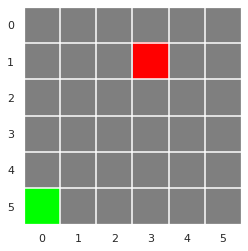

In [31]:
import numpy as geek
def render_state(state) : 


    dim2D = int(state.shape[0]**0.5)
    state = state.reshape(dim2D, dim2D).astype(int)
    out_tpl = geek.nonzero(state)
    pos = [out_tpl[0][0], out_tpl[1][0]]

    env.render_state(pos)

state = np.zeros((env._state_dim))
state[9]  = 1
render_state(state)

In [32]:
def plot_stat(data, param , col) : 
    stat = []
    stat_all = []
    for episode in range(param["num_episodes"]) : 

        mean = data.loc[lambda df: df['Episode'] == episode][col].mean()
        quantile10 = data.loc[lambda df: df['Episode'] == episode][col].quantile(0.1)
        quantile90 = data.loc[lambda df: df['Episode'] == episode][col].quantile(0.9)
        
        stat_all.append(data.loc[lambda df: df['Episode'] == episode][col].values   )

        stat.append([mean, quantile10, quantile90])
        
    data_stat = pd.DataFrame(stat, columns=[ "mean", "quantile10","quantile90"]     )
    


    # set seaborn style
    sns.set_theme()

    # Data
    x=range(param_agent_simu["num_episodes"])
    y=[ data_stat["quantile10"], data_stat["mean"], data_stat["quantile90"]]

    # Plot
    plt.stackplot(x,y, labels=['quantile10','mean','quantile90'])
    plt.legend(loc='upper left')
    plt.show()
    
    
    return data_stat, np.array(stat_all)

In [33]:
def box_plot(data,param, col) : 


    data_Q_episode_par_10 = pd.DataFrame()


    for k in range(0,param["num_episodes"], 10) : 
        data_Q_episode_par_10 = pd.concat([data_Q_episode_par_10,
                                          data.loc[lambda df: df['Episode'] == k]])


    fig, axs = plt.subplots(1, 1,figsize=(15, 5))
    sns.boxplot( x=data_Q_episode_par_10["Episode"], y=data_Q_episode_par_10[col] )
    
    return data_Q_episode_par_10

In [34]:
def carac_model(param) : 
    if param["train_LSFM"] : calcul = "LSFM"
    else : 
        if param["train_on_Q_latent"]  : calcul = "Q_latent"
        else : calcul = "Q"
        if param["model_Q_Lin"]  : calcul+="_Lin"
        else : calcul+="_Deep"
    
    return calcul

# Exploration - Eigen value

In [35]:
sqdfv sdfv xsdfv xdfv dxfv xdfv 

SyntaxError: invalid syntax (<ipython-input-35-b4106700868c>, line 1)

# Train offline

### train exp Offline

In [ ]:
# df = pd.read_csv("memory_simple.csv")
# df["observation"] = df["observation"].apply(eval)
# df["action_mask"] = df["action_mask"].apply(eval)
# df["new_observation"] = df["new_observation"].apply(eval)

# buff_df =df


# Ends = buff_df.loc[buff_df["finished"]==True]
# nb_ep = len(Ends)
# nb_Ep_train = int(nb_ep*0.8)
# nb_Ep_test = nb_ep - int(nb_ep*0.8)

# id_train = buff_df.loc[buff_df["finished"]==True].iloc[nb_Ep_train].name

# buffer_train = list(buff_df.loc[0:id_train].values)
# buffer_test = list(buff_df.loc[id_train+1:].values)

# fig, axs = plt.subplots(1,2, figsize=(13, 5))

# sns.distplot(buff_df['reward'], ax = axs[0]).set(title='Reward distribution')
# sns.distplot(Ends['reward'], ax = axs[1]).set(title='Reward distribution on at the end of episode')




# choice of environment  : 




buffer = buffer_train


param_agent_simu = {}
param_agent_simu = param_agent.copy()
param_agent_simu["latent_space"] = 36
param_agent_simu["run"] = 1
# param_agent_simu["num_episodes"] = int(nb_episodes*0.8)
param_agent_simu["double_model"] = False
param_agent_simu["avg_loss_phisp1"] = 1000


agent_LSFM = Agent(environment, param_agent_simu)
model_LSFM = agent_LSFM.model_LSFM
model_LSFM.summary()

In [ ]:

id_train = len(buffer)
param_agent_simu["num_steps"]    = 7000
# param_agent_simu["num_steps"]    = 1000


data_xp = pd.DataFrame()
# for eigen in [0,4,8,16,32, 64] : 
for alpha_N in [0.01,0.1,1.] : 
    param_agent_simu["alpha_N"] = alpha_N
    for alpha_psi in [0.01,0.1,1.] : 
        param_agent_simu["alpha_psi"] = alpha_psi
        
        data, agent_LSFM = experience_offline_LSFM(environment,param_agent_simu,buffer)

        data["alpha_N"] = alpha_N
        data["alpha_psi"] = alpha_psi

        data_xp = pd.concat([data_xp, data])

data_offline = data_xp
        
data_offline.to_csv('data_offline.csv')

In [ ]:


fig, axs = plt.subplots(2, 3,figsize=(15, 10))
plt.figure(figsize=(5, 5))

# for option in options : 
sns.lineplot(x="cum_step", y="Avg_loss",  hue='alpha_N', data=data_offline, ax = axs[0,0] )
sns.lineplot(x="cum_step", y="Avg_loss_r",  hue='alpha_psi', data=data_offline, ax = axs[0,1] )
# sns.lineplot(x="cum_step", y="Avg_loss_psi",  hue='eigen', data=data_offline, ax = axs[0,2] )
# sns.lineplot(x="cum_step", y="Avg_loss_phip1",  hue='eigen', data=data_offline, ax = axs[1,0] )
# sns.lineplot(x="cum_step", y="overlappping",  hue='eigen', data=data_offline, ax = axs[1,1] )
# sns.lineplot(x="cum_step", y="exploration_ratio",  hue='eigen', data=data_offline, ax = axs[1,2] )

In [ ]:
data_offline

In [ ]:
agent.model_LSFM.summary()
keras.utils.plot_model(agent.model_LSFM, "my_first_model.png", show_shapes=True)

In [ ]:
data_train_df

fig, axs = plt.subplots(2, 3,figsize=(15, 10))
plt.figure(figsize=(5, 5))
sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, ax = axs[0,0] )
sns.lineplot(x="cum_step", y="Avg_loss_r", data=data_train_df, ax = axs[0,1] )
sns.lineplot(x="cum_step", y="Avg_loss_N", data=data_train_df, ax = axs[0,2] )
sns.lineplot(x="cum_step", y="Avg_loss_psi", data=data_train_df, ax = axs[1,0] )


plt.show()

In [ ]:

agent_LSFM.model_LSFM.save_weights(folder_WORK+"/agent_LSFM_model")

### test error

In [ ]:
buffer_test

In [ ]:
%%time
# choice of environement  : 
environment = env
param_agent_simu = {}
param_agent_simu = param_agent.copy()
param_agent_simu["num_episodes"] = nb_Ep_test-1


# folder = "LSFM_V2.5_dim1.2-hidden_ratio_22021-06-22_14h-31m-15s"
# folder = "LSFM_NO_SMOTE_GOOD"
folder = "LSFM_classif_Ma"


save_model_path = folder+"/agent_LSFM_model"

y_pred_df, y_true_df= test_error_Ma_rewClassif_offline_LSFM(
    env,param_agent_simu, buffer_test, save_model_path, param_agent["reward_parser" ])

In [ ]:

from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score



#  roc_curve(y_test.ravel(), y_score.ravel())


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score



y_pred = y_pred_df["reward_one-step"].apply(np.argmax)
y_true = y_true_df["reward_one-step"]
y_pred, y_true
accuracy_score(y_true, y_pred),

In [ ]:
y_true.unique()

In [ ]:

from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix


parser =  param_agent["reward_parser" ]
reward_classes = [[-np.inf,parser[0]]] + [[parser[k],parser[k+1]]  for k in range(len(parser)-1)] + [[parser[-1], np.inf]]



def classif(y_true, y_pred, dt_string, label = None) : 

#     reward_classes = [[-np.inf,parser[0]]] + [[parser[k],parser[k+1]]  for k in range(len(parser)-1)] + [[parser[-1], np.inf]]
    classes = y_true.unique()
    reward_classes = classes
    
    if label != None : reward_classes = label
        
    conf = multilabel_confusion_matrix(y_true, y_pred, labels=classes)
    conf

    error_classif = []

    for i,conf_bin in enumerate(conf) : 
        TN = conf_bin[0][0]
        FP = conf_bin[0][1]
        FN = conf_bin[1][0]
        TP = conf_bin[1][1]
        labels = np.array([["True Neg : {} \n or {:2.1f} % ".format(TN,100*TN / np.sum(TN + FP + FN + TP)),
                            "False Pos : {} \n or {:2.1f} % ".format(FP,100*FP / (TN + FP + FN + TP))],
                           ["False Neg : {} \n or {:2.1f} % ".format(FN,100*FN / (TN + FP + FN + TP)),
                            "True Pos : {} \n or {:2.1f} % ".format(TP,100*TP / (TN + FP + FN + TP))     ]])
        recall = TP / (FN + TP)
        precision = TP / (FP + TP)
        f1 = 2* recall * precision / (recall + precision)

        error_classif.append([recall, reward_classes[classes[i]] , "recall"])
        error_classif.append([precision, reward_classes[classes[i]] , "precision"])
        error_classif.append([f1, reward_classes[classes[i]] , "f1"])


        fig, ax = plt.subplots()
        sns.heatmap(conf_bin ,annot=labels, fmt="" , cmap='Blues').set(
            title='confusion matrix for rewards in {}'.format(reward_classes[classes[i]]))
    #         plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')


    # sns.heatmap(cf_matrix, annot=labels, fmt=‘’, cmap='Blues')
     
        plt.savefig(folder+"/"+dt_string+"confusion_"+str(i)+".jpg")
        plt.show()
    error_classif_df = pd.DataFrame(error_classif, columns = ["error", "reward_classes", "type"])
    return error_classif_df
# sns.heatmap(conf)classif(y_true, y_pred, dt_string, label = reward_classes)
error_classif_df = classif(y_true, y_pred, dt_string, label = reward_classes)

In [ ]:
error_classif_df

In [ ]:

y_pred = y_pred_df["reward_n-step"].apply(np.argmax)
y_true = y_true_df["reward_n-step"]
# classif(y_true, y_pred, reward_classes)

In [ ]:
error_classif_df["reward_classes"] = error_classif_df["reward_classes"].astype(str)

In [ ]:

fig , ax = plt.subplots()
sns.barplot(x="reward_classes", y="error", hue = "type", data=error_classif_df)
plt.show()
plt.savefig(folder+"/"+dt_string+"_classif_error"+".jpg")

### post error

In [ ]:

y_pred_df.columns

In [ ]:
from sklearn.metrics import r2_score

def norm(vect) : 
    return tf.keras.backend.get_value(tf.norm(vect, ord='euclidean'))



def losses_reg(col, y_pred_df, y_true_df) : 

    ypred = y_pred_df[col]
    ytrue = y_true_df[col]    
    
    MSE, MAE = [None, None]
    
    if (ytrue.empty or ypred.empty) : return [MSE, MAE, col]
    
    if (ytrue.dtypes == "float64" or ytrue.dtypes == "float32" or ytrue.dtypes == float): 
        
        MSE = tf.keras.backend.get_value(keras.losses.mean_squared_error(ypred, ytrue))
        MAE = tf.keras.backend.get_value(keras.losses.mean_absolute_error(ypred, ytrue))
#         r2 = r2_score(ypred, ytrue)
    elif (ytrue.dtypes == "object"): 
        
        df = ytrue - ypred
        df = ytrue - ypred
        MSE =  df.apply(norm).sum()/len(df)
        MAE = None
        
    return [MSE, MAE, col]
losses_reg("Norm_phi", y_pred_df, y_true_df)

In [ ]:
def global_loss_reg(y_pred_df, y_true_df) : 
    errors = []
    for col in y_pred_df.columns : 
        errors.append(losses_reg(col, y_pred_df, y_true_df))

    errors_df = pd.DataFrame(errors, columns=["MSE", "MAE", "error"])
        
    return errors_df

global_loss_reg(y_pred_df.loc[:, ['Norm_phi', 'target_psi', 'phi_sp1']], y_true_df.loc[:, ['Norm_phi', 'target_psi', 'phi_sp1']])

# global_loss(y_pred_df, y_true_df)


    # errors_df = pd.DataFrame(errors, columns=["MSE", "MAE", "r2", "error"])
#     errors_df = pd.DataFrame(errors, columns=["MSE", "MAE", "error"])
#     errors_df

In [ ]:
reward_class = 3
y_true_df.loc[y_true_df["reward_one-step"]==reward_class]

In [ ]:
def losses_on_reward_class(col, y_pred_df, y_true_df, reward_class = 2, nb_actions = 4) : 
    
    losses_action = []
    df = y_true_df
    
    for action in range(nb_actions):
        id_action = list(df.loc[df["reward_one-step"]==reward_class].loc[
                df["action"]==action].index)            
        
        loss = losses_reg(col, y_pred_df.loc[id_action], y_true_df.loc[id_action])

        loss.insert(0, action)

        losses_action.append(loss)

    loss_action_df = pd.DataFrame(losses_action, columns=["action", "MSE", "MAE", "error"])
        
    return loss_action_df

y_pred_df



    

cols = ['Norm_phi', 'target_psi', 'phi_sp1']

    

losses_on_reward_class(cols[0], y_pred_df, y_true_df, reward_class = 3, nb_actions = 4) 
    

In [ ]:
y_pred_df.loc[:, cols]

In [ ]:
def losses_on_rewards_global(cols, y_pred_df, y_true_df, reward_class = 2, nb_actions = 4) : 
    data = pd.DataFrame()
    for col in list(cols) : 
        loss = losses_on_reward_class(
            col, y_pred_df, y_true_df, reward_class = reward_class, nb_actions = nb_actions) 
        data = pd.concat([data, loss])
    return data


cols = ['Norm_phi', 'target_psi', 'phi_sp1']

losses_on_rewards_global(cols, 
    y_pred_df.loc[:, "action":], y_true_df.loc[:, "action":],reward_class = 3,nb_actions= 4 )
# reward_positive = losses_on_positive_rewards_global(y_pred_df.loc[:, "action":], y_true_df.loc[:, "action":], thresold = 0.5, nb_actions = 4) 

#### plot

In [ ]:
y_pred_df.loc[:, ["reward_one-step", "Norm_phi" ]]

In [ ]:

cols = ['Norm_phi', 'target_psi', 'phi_sp1']



df = losses_on_rewards_global(cols, 
    y_pred_df, y_true_df,reward_class = 2,nb_actions= 4 )


# global_loss(y_pred_df.loc[:, cols], y_true_df.loc[:,cols])

In [ ]:

cols = ["Norm_phi"   , "target_psi"    , "phi_sp1"  ] 
metric = "MSE"

global_losses = global_loss_reg(y_pred_df.loc[:, cols], y_true_df.loc[:,cols])
global_losses


In [ ]:

fig , ax = plt.subplots()

sns.barplot(x="error", y="MSE", data=global_losses).set(
    title='Test global errors', xlabel="")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.savefig(folder+"/"+dt_string+"_reg_error"+".jpg")
plt.show()

In [ ]:
reward_classes = [[-np.inf,parser[0]]] + [[parser[k],parser[k+1]]  for k in range(len(parser)-1)] + [[parser[-1], np.inf]]
len(reward_classes)

In [ ]:


nb_actions = env._action_dim


rewards_window = []

for i in range(len(reward_classes)) : 
    print("reward_class", i)
    rewards_window.append(losses_on_rewards_global(cols,
        y_pred_df.loc[:, "action":], y_true_df.loc[:, "action":], 
        reward_class =i, nb_actions=nb_actions))

rewards_window

In [ ]:
rewards_window[0].loc[:,"MSE":"MAE"].applymap(lambda x: x is None).all().all()

In [ ]:
metric = "MSE"
    
for i in range(len(reward_classes)) : 
    
    
    
    if rewards_window[i].loc[:,"MSE":"MAE"].applymap(lambda x: x is None).all().all() : 
    
        print("No value for class", i)
    else :       
        fig , ax = plt.subplots()
        dataplot_i = rewards_window[i].fillna(value=np.nan)
        
        sns.boxplot(x="error", y=metric,  data=dataplot_i).set(
            xlabel="", title='Test errors on reward class {} by actions'.format(reward_classes[i]))
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
        plt.savefig(folder+"/"+dt_string+"_reg_class_"+str(i)+".jpg")
        

In [ ]:
# global_losses["set part"] = "all"
# reward_positive["set part"] = "positive_reward"
# data = pd.concat([global_losses, reward_positive])

# data_plot   = data.loc[data["error"]  !="action"  ]
# data_plot
# fig, axs = plt.subplots(figsize=(7, 5))
# axs.set_title('Errors on data set part')
# sns.barplot(x="error", y="MSE", hue="set part", data=data_plot)
# plt.xticks(rotation=45, fontsize=10, horizontalalignment='right')


In [ ]:
# def line_plot(Ep, col, y_pred_df, y_true_df) : 
    
#     line_pred = y_pred_df.loc[y_pred_df["Ep"] == Ep, col]
#     line_true = y_true_df.loc[y_true_df["Ep"] == Ep, col]

#     line_pred, line_true
#     plt.figure(figsize=(10, 5))
#     sns.lineplot(data=line_pred)
#     sns.lineplot(data=line_true)
    
#     return line_pred, line_true
# for k in range(30) : 
#     line_pred, line_true = line_plot( k, "reward_n-step", y_pred_df, y_true_df)
# print("reward_pred : \n", line_pred)
# print("last action :",  buffer_test[line_pred.index[-1]][2] )


## __SAVE__ LSFM in './agent_LSFM_model'

In [ ]:
# agent_LSFM.model_LSFM.save( folder_WORK+"/agent_LSFM_model")


In [ ]:

# plt.figure(figsize=(5, 5))
# sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, label="Avg_loss" )
# sns.lineplot(x="cum_step", y="Avg_loss_r", data=data_train_df, label="Avg_loss_r" )
# sns.lineplot(x="cum_step", y="Avg_loss_N", data=data_train_df , label="Avg_loss_N")
# sns.lineplot(x="cum_step", y="Avg_loss_psi", data=data_train_df , label="Avg_loss_psi")
# plt.legend()

# plt.savefig(folder_WORK+"/"+dt_string+"loss_LSFM.jpg")
# plt.show()

# Train online

## experiment

In [36]:
import time   

def loss_func(ypred, ytrue) : 
#     MSE
    return keras.losses.mean_squared_error(ypred, ytrue)

def init_count(environment) : 

        
    states_free_tab = []
    n = environment._state_dim
    grid_size = n**0.5

    
    
    states_block = [point[0] * grid_size + point[1] for point in environment.env.blocks]
    
    for i in range(n) :
         if i not in states_block : 
            states_free_tab.append(i)
    
    states_free_tab = np.array(states_free_tab) 
    
    count_explore = np.zeros(len(states_free_tab))
    
    return count_explore, states_free_tab



def exploration_count(state, count_explore,states_free_tab ) : 
    
    count = count_explore
    i = np.where(state>0)[0][0]
    i_free_state = np.where(np.array(states_free_tab) == i)[0][0]
    count[i_free_state]+=1
    return count


def simu_online_eigen(environment, param_agent, eigenoption = True) : 


#  --------------------------------------------------------------------------------
#   init count expore for environment overlapping and exploration ratio
    count_explore, states_free_tab = init_count(environment)
#  --------------------------------------------------------------------------------

    
    
    param_agent = param_agent_simu

    result_compile = []
    steps = 0

    
    render = param_agent["render"]
    reward_cumul = 0

    #     No mask for simple environment
    if environment.env_name == "SimpleGrid" : 
        action_space = np.arange(environment.action_space.n)
        action_no_mask = np.full((environment.action_space.n), 1)   
        possible_action = action_space


    memory = Memory(param_agent["memory"])

    avg_loss = 0
    avg_loss_r  = 0
    avg_loss_N  = 0
    avg_loss_psi  = 0

    agent_LSFM = Agent(environment, param_agent)
    model_LSFM = agent_LSFM.model_LSFM


    value, vect = agent_LSFM.eigen_decomp(model_LSFM)

    ### TRANSITION MATRIX : get the period for the calculation, and init M
    step_loss_phisp1 = param_agent["avg_loss_phisp1" ]


    # if step_loss_phisp1 > 0 : 
    #     agent_LSFM.M_transi(model_LSFM)

    for i in range(param_agent["num_episodes"]):

        reward_ep_cumul = 0
        cnt = 0
        avg_loss = 0

    ### TRANSITION MATRIX :  initialize the loss
        loss_phisp1  = 0

        state = environment.reset() 
        if step_loss_phisp1 > 0 :  
            phis_pred = model_LSFM(state.reshape(1,-1))["phi"]

        agent.plot_eigenvect(model_LSFM, "eigenvect_" + str(i) + "_ep.png")
        

        while True:
            
            
            
            
            if render:
                environment.render()
                
                  ### Update Fa eigen_decomp every 50 steps
            if steps % 50 == 0 : agent.eigen_decomp(agent.model_LSFM)

            #  --------------------------------------------------------------------------------
            #   compute count expore for environment overlapping and exploration ratio
            count_explore = exploration_count(state, count_explore, states_free_tab)
            overlapping = sum([ elem -1 for elem in count_explore if elem>1])
            exploration_ratio = 1 - len([ elem for elem in count_explore if elem <= 0]) / len(count_explore)
            #  --------------------------------------------------------------------------------
                
                
                
                
                
    #             -----------------------------
    #             random Policy

            phis = agent_LSFM.model_LSFM(state.reshape(1,-1))["phi"]
            mask_action = [1,1,1,1]         
            
            
            if eigenoption : 
                actions = agent_LSFM.exploration_online(model_LSFM, 
                                                        phis, 
                                                        mask_action, 
                                                        steps, 
                                                        start_eigenoption = param_agent["start_eigenoption"])
            else : 
                actions = agent_LSFM.choose_action_random()
            
            
            action = actions[0]


            next_state, reward, done, info = environment.step(action)

            phi_prime = agent_LSFM.model_LSFM(next_state.reshape(1,-1))["phi"]
            next_state_latent = np.array(tf.reshape(phi_prime, phi_prime.shape[-1]))


    ### TRANSITION MATRIX :update every step_loss_phisp1 the transition matrix
    #         if step_loss_phisp1 > 0 and (steps + 1) % step_loss_phisp1 == 0 :    
    #             start_time = time.time()
    #             agent_LSFM.M_transi(model_LSFM)
    #             print("--- steps {} : M_transi take {} seconds ---".format(
    #                 steps, time.time() - start_time) )

    ### TRANSITION MATRIX : Get the prediction error of the next latent space
            if step_loss_phisp1 > 0 :             
    #             print("phis_pred, action", phis_pred, action)
                phisp1_pred = agent_LSFM.next_phi_pred(model_LSFM, phis_pred,[action])
                loss_phisp1   += loss_func(phi_prime, phisp1_pred).numpy()[0]

    #                 print('loss_phisp1', loss_func(phi_prime, phisp1_pred).numpy()[0], loss_phisp1)

            if param_agent["RANDOM_REWARD_STD"] > 0:
                reward = np.random.normal(1.0, RANDOM_REWARD_STD)

            reward_ep_cumul += reward
            reward_cumul += reward

            if done:
                next_state = np.zeros(environment._state_dim)
                next_state_latent = np.zeros(param_agent["latent_space"])


    #             -----------------------------
    #             add Sample in memory
    #             -----------------------------   
            memory.add_sample((state, action_no_mask, action, reward, next_state, done))
            if steps%200 == 0 : 
                    memory = clean_duplicate(memory)
                    print("memory clean", steps)
    #             -----------------------------
    #             TRAIN LSFM
    #             -----------------------------

            loss_all = agent_LSFM.train_LSFM(
                model_LSFM, 
                memory, 
                param_agent["filter_done"])

            avg_loss += loss_all[0]
            avg_loss_r += loss_all[1]
            avg_loss_N += loss_all[2]
            avg_loss_psi += loss_all[3]


            state = next_state

            if step_loss_phisp1 > 0 :                     
                phis_pred = phisp1_pred

            steps += 1
            if steps % 1000 == 0 : print("steps : {}, episode : {}".format(steps, i))

            

            
            if cnt == param_agent["steps_max_episode"] : done = True
            
            if done:

                if cnt != 0:
                    avg_loss /= cnt
                    avg_loss_r /= cnt
                    avg_loss_N /= cnt
                    avg_loss_psi /= cnt
                    loss_phisp1 /= cnt

                else:
                    avg_loss = 0
                    loss_phisp1 = 0
                
                result = [i, cnt, steps, reward_ep_cumul,
                          reward_cumul, avg_loss, avg_loss_r, avg_loss_N, avg_loss_psi,
                          loss_phisp1,overlapping, exploration_ratio]

                result_compile.append(result)
                
                if i % 1  == 0 : 

                    result_print = [y for x in [result[0:3], result[5:]] for y in x]
                    print(
                    "Ep: {:03d}, stEp: {:03d}, stAll: {:04d}, L: {:0.4f}, Lr: {:0.4f},Ln: {:0.4f}, Lpsi: {:0.4f}, Lphi: {:0.4f}".format(*result_print[:]))

                
    #             with train_writer.as_default():
    #                 tf.summary.scalar('reward', cnt, step=i)
    #                 tf.summary.scalar('avg loss', avg_loss, step=i)
                break

            cnt += 1
    return result_compile, agent_LSFM, memory



def experience_oneline_eigenoption(environment, param_agent,  eigenoption = True) : 
    
    data = pd.DataFrame()
    
    for k in range(param_agent["run"]) : 
    
        result_compile, agent_LSFM, memory = simu_online_eigen(environment, param_agent, eigenoption)     
        
        data_train_df = pd.DataFrame(result_compile, columns=[ 
            "Episode", 
            "Step", 
            "cum_step",
            "Reward", 
            "Reward_cum",  
            "Avg_loss" ,  
            "Avg_loss_r",  
            "Avg_loss_N",  
            "Avg_loss_psi",
            "Avg_loss_phip1", 
            "overlappping", 
            "exploration_ratio"])
        
        
        data_train_df["carac"] = carac_model(param_agent) 
        data_train_df["run"] = k
        data = pd.concat([data, data_train_df])
        
        
    return data, agent_LSFM, memory

## run

In [ ]:

environment = env_change_reward



param_agent_simu = {}
param_agent_simu = param_agent.copy()
param_agent_simu["latent_space"] = 121


param_agent_simu["policy"]["type"] = ["eps-greedy", "exponantial"]
param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] = 0.002


param_agent_simu["run"] = 5
param_agent_simu["double_model"] = False
param_agent_simu["avg_loss_phisp1"] = 1000
# id_train = len(buffer)
# param_agent_simu["num_steps"]    = id_train+2
param_agent_simu["num_steps"]    = 10000


param_agent_simu["start_eigenoption"] = 10
param_agent_simu["steps_max_episode"] = 150
param_agent_simu["eigenoption_number"] = 16
param_agent_simu["num_episodes"] = 10
param_agent_simu["discoverNegation"] = True


data_eigen = pd.DataFrame()
for eigen in [16] : 
    param_agent_simu["eigenoption_number"] = eigen
    for _lambda in [0., 0.001] : 
        param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] = _lambda           

        data, agent_LSFM , memory = experience_oneline_eigenoption(
            environment, param_agent_simu,  eigenoption = True) 

#         data["eigen"] = eigen
        data["lambda_exp"] = _lambda

        data_eigen = pd.concat([data_eigen, data])
    
data_eigen


# \******************************

# data, agent_LSFM , memory = experience_oneline_eigenoption(environment, param_agent_simu,  eigenoption = False) 





memory clean 0
Ep: 000, stEp: 150, stAll: 0151, L: 0.2054, Lr: 0.1521,Ln: 0.5326, Lpsi: 0.0028, Lphi: 0.0114
memory clean 200
Ep: 001, stEp: 150, stAll: 0302, L: 0.0662, Lr: 0.0355,Ln: 0.3203, Lpsi: 0.0021, Lphi: 0.0052
memory clean 400
Ep: 002, stEp: 150, stAll: 0453, L: 0.0306, Lr: 0.0166,Ln: 0.1439, Lpsi: 0.0010, Lphi: 0.0057
memory clean 600
Ep: 003, stEp: 150, stAll: 0604, L: 0.0208, Lr: 0.0123,Ln: 0.0860, Lpsi: 0.0021, Lphi: 0.0133
Ep: 004, stEp: 150, stAll: 0755, L: 0.0112, Lr: 0.0073,Ln: 0.0408, Lpsi: 0.0007, Lphi: 0.0005
memory clean 800
Ep: 005, stEp: 150, stAll: 0906, L: 0.0065, Lr: 0.0046,Ln: 0.0201, Lpsi: 0.0003, Lphi: 0.0002
steps : 1000, episode : 6
memory clean 1000
Ep: 006, stEp: 150, stAll: 1057, L: 0.0040, Lr: 0.0030,Ln: 0.0102, Lpsi: 0.0002, Lphi: 0.0006
memory clean 1200
Ep: 007, stEp: 150, stAll: 1208, L: 0.0027, Lr: 0.0021,Ln: 0.0062, Lpsi: 0.0004, Lphi: 0.0006
Ep: 008, stEp: 150, stAll: 1359, L: 0.0020, Lr: 0.0016,Ln: 0.0042, Lpsi: 0.0005, Lphi: 0.0005
memory cl

In [ ]:
data_plot = data_eigen

In [ ]:
data_plot["eigen"] = True
data_plot.loc[data_plot["lambda_exp"] == 0, "eigen"] = False
data_plot

In [ ]:

fig, axs = plt.subplots(2, 3,figsize=(25, 15))
plt.figure(figsize=(5, 5))

# for option in options : 
sns.lineplot(x="cum_step", y="Avg_loss",  hue='lambda_exp', style = "eigen", data=data_plot, ax = axs[0,0] )
sns.lineplot(x="cum_step", y="Avg_loss_r",  hue='lambda_exp', style = "eigen", data=data_plot, ax = axs[0,1] )
sns.lineplot(x="cum_step", y="Avg_loss_psi",  hue='lambda_exp', style = "eigen", data=data_plot, ax = axs[0,2] )
sns.lineplot(x="cum_step", y="Avg_loss_phip1",  hue='lambda_exp', style = "eigen", data=data_plot, ax = axs[1,0] )
sns.lineplot(x="cum_step", y="overlappping",  hue='lambda_exp', style = "eigen", data=data_plot, ax = axs[1,1] )
sns.lineplot(x="cum_step", y="exploration_ratio",  hue='lambda_exp', style = "eigen", data=data_plot, ax = axs[1,2] )

In [ ]:
data_16_option = data_plot.loc[data_plot["eigenoption_number"] == 16 ]
data_0_option = data_plot.loc[data_plot["eigenoption_number"] ==  0 ]
data_0_16_option = pd.concat([data_0_option, data_16_option])

In [ ]:

fig, axs = plt.subplots(2, 3,figsize=(25, 15))
plt.figure(figsize=(5, 5))

# for option in options : 
sns.lineplot(x="cum_step", y="Avg_loss",  hue='eigenoption_number', style = "eigen", data=data_0_16_option, ax = axs[0,0] )
sns.lineplot(x="cum_step", y="Avg_loss_r",  hue='eigenoption_number', style = "eigen", data=data_0_16_option, ax = axs[0,1] )
sns.lineplot(x="cum_step", y="Avg_loss_psi",  hue='eigenoption_number', style = "eigen", data=data_0_16_option, ax = axs[0,2] )
sns.lineplot(x="cum_step", y="Avg_loss_phip1",  hue='eigenoption_number', style = "eigen", data=data_0_16_option, ax = axs[1,0] )
sns.lineplot(x="cum_step", y="overlappping",  hue='eigenoption_number', style = "eigen", data=data_0_16_option, ax = axs[1,1] )
sns.lineplot(x="cum_step", y="exploration_ratio",  hue='eigenoption_number', style = "eigen", data=data_0_16_option, ax = axs[1,2] )

In [ ]:


fig, axs = plt.subplots(2, 3,figsize=(25, 15))
plt.figure(figsize=(5, 5))

# for option in options : 
sns.lineplot(x="cum_step", y="Avg_loss",  hue='eigenoption_number', style = "eigen", data=data_plot, ax = axs[0,0] )
sns.lineplot(x="cum_step", y="Avg_loss_r",  hue='eigenoption_number', style = "eigen", data=data_plot, ax = axs[0,1] )
sns.lineplot(x="cum_step", y="Avg_loss_psi",  hue='eigenoption_number', style = "eigen", data=data_plot, ax = axs[0,2] )
sns.lineplot(x="cum_step", y="Avg_loss_phip1",  hue='eigenoption_number', style = "eigen", data=data_plot, ax = axs[1,0] )
sns.lineplot(x="cum_step", y="overlappping",  hue='eigenoption_number', style = "eigen", data=data_plot, ax = axs[1,1] )
sns.lineplot(x="cum_step", y="exploration_ratio",  hue='eigenoption_number', style = "eigen", data=data_plot, ax = axs[1,2] )

In [ ]:
data_plot.to_csv('data_plot_exploration_run5.csv')

In [ ]:
# df_0 = data_eigen.loc[data_eigen["eigenoption_number" ]== 0]
# df_4 = data_eigen.loc[data_eigen["eigenoption_number" ]== 4]
# df_16 = data_eigen.loc[data_eigen["eigenoption_number" ]== 16]
# df_64 = data_eigen.loc[data_eigen["eigenoption_number" ]== 64]



# steps_missing =  [step for step in data_eigen["cum_step"].unique() if step not in df_0["cum_step"].unique() ]
# print(len(steps_missing))
# row = df_0.iloc[0:2]

# row.iloc[:,:] = np.nan
# row_add = row


# for k,step in enumerate(steps_missing) : 
    
#     row.append(row_add)
# row
# # row.loc[:,:] = np.nan
# # # row.iloc[0,2]
# # # row.reindex(list( range(len(steps_missing))))
# # len(row)
# # # row.iloc[:,2]
# # # pd.concat([df_0, df_4, df_16, df_64],  join="inner")
# # # 

In [ ]:
# data_eigen.iloc[0,:] = [0,300,301,0.0,0.0,1.177262,1.176331,2.439530e-15,0.004247,0.008292,276.0,0.240385,"LSFM",0,0,0.5, 0.]

In [ ]:
# data_eigen["cum_step"].unique()

In [ ]:
# data_eigen["style"] = 0
# data_eigen.loc[data_eigen["eigenoption_number"] == 0, "style"] = 1
# data_eigen

In [ ]:
# df_0 = data_eigen.loc[data_eigen["eigenoption_number" ]== 0]
# df_4 = data_eigen.loc[data_eigen["eigenoption_number" ]== 4]
# df_16 = data_eigen.loc[data_eigen["eigenoption_number" ]== 16]
# df_64 = data_eigen.loc[data_eigen["eigenoption_number" ]== 64]

# df = pd.DataFrame(columns=data_eigen.columns)
# df

# all_step = data_eigen["cum_step"].unique()

# for i in range(len(all_step)):
#     df = df.append({'cum_step': all_step[i]}, ignore_index=True)
# # df.loc[:,"eigen_exploitation"] = 0.
# df
# df_0_augmented = pd.concat([df_0 , df])

# df_0_augmented

# fig, axs = plt.subplots(2, 3,figsize=(15, 10))
# plt.figure(figsize=(5, 5))

# # for option in options : 
# sns.lineplot(x="Episode", y="exploration_ratio",hue = "eigenoption_number", data=df_0, ax = axs[0,0] )
# df_0_augmented.interpolate()

# # .interpolate()
# # df_4 = pd.concat([df_4 , df]).interpolate()
# # df_16 = pd.concat([df_16 , df]).interpolate()
# # df_64 = pd.concat([df_64 , df]).interpolate()
# # data_augmented = pd.concat([df_0,df_4,df_16,df_64 ])

In [ ]:


# fig, axs = plt.subplots(2, 3,figsize=(15, 10))
# plt.figure(figsize=(5, 5))

# # for option in options : 
# sns.scatterplot(x="cum_step", y="Avg_loss",hue = "eigenoption_number", data=data_eigen, ax = axs[0,0] )
# sns.scatterplot(x="cum_step", y="Avg_loss_r",hue = "eigenoption_number", data=data_eigen, ax = axs[0,1] )
# sns.scatterplot(x="cum_step", y="Avg_loss_psi",hue = "eigenoption_number", data=data_eigen, ax = axs[0,2] )
# sns.scatterplot(x="cum_step", y="Avg_loss_phip1",hue = "eigenoption_number", data=data_eigen, ax = axs[1,0] )
# sns.scatterplot(x="cum_step", y="overlappping",hue = "eigenoption_number", data=data_eigen, ax = axs[1,1] )
# sns.scatterplot(x="cum_step", y="exploration_ratio",hue = "eigenoption_number", data=data_eigen, ax = axs[1,2] )

In [ ]:


# fig, axs = plt.subplots(2, 3,figsize=(15, 10))
# plt.figure(figsize=(5, 5))

# # for option in options : 
# sns.lineplot(x="cum_step", y="Avg_loss",  hue='eigen_exploitation', data=data_eigen, ax = axs[0,0] )
# sns.lineplot(x="cum_step", y="Avg_loss_r",  hue='eigen_exploitation', data=data_eigen, ax = axs[0,1] )
# sns.lineplot(x="cum_step", y="Avg_loss_psi",  hue='eigen_exploitation', data=data_eigen, ax = axs[0,2] )
# sns.lineplot(x="cum_step", y="Avg_loss_phip1",  hue='eigen_exploitation', data=data_eigen, ax = axs[1,0] )
# sns.lineplot(x="cum_step", y="overlappping",  hue='eigen_exploitation', data=data_eigen, ax = axs[1,1] )
# sns.lineplot(x="cum_step", y="exploration_ratio",  hue='eigen_exploitation', data=data_eigen, ax = axs[1,2] )

In [ ]:

# def visu(visu_state, grid_size, axs) : 
    
#     axs.imshow(visu_state, aspect="auto")

#     axs.set_xticks(np.arange(-.5, grid_size - 1, 1), minor=True)
#     axs.set_yticks(np.arange(-.5, grid_size - 1, 1), minor=True)
#     axs.grid(which='both', color='w', linestyle='-', linewidth=1.5)
    
    
#     axs.tick_params(left=False,
#                 bottom=False,
#                 labelleft=False,
#                 labelbottom=False)

    
    
# agent = agent_LSFM

# n_eigen_value = 16

# ncol = 5
# nrow = int(n_eigen_value / ncol) + 1

# value, vect = agent.eigen_decomp(agent.model_LSFM)

# n = environment._state_dim  
# ngrid = int(n**0.5)


# fig, axs = plt.subplots(nrow, ncol , figsize=(5*ncol, 5*ncol * nrow/ncol))
# for idx in range(n_eigen_value) : 
#     visu(tf.reshape(vect[ idx ], (ngrid, ngrid)) ,ngrid, axs[idx//ncol,idx%ncol]) 
# value

## exploitation


In [ ]:
data_result = pd.read_csv('Results_dataeigenoption/data_eigen.csv')
data_result["no_eigen"] = False
data_result.loc[data_result["eigen"] == 0,"no_eigen"] = True
data_result


In [ ]:
data_result.loc[data_result["eigen"] == ]

In [ ]:
from matplotlib import cm






fig, axs = plt.subplots(2, 3,figsize=(15, 10))
plt.figure(figsize=(5, 5))

# for option in options : 
sns.lineplot(x="cum_step", y="Avg_loss",  hue='eigen', style = "no_eigen", data=data_result, ax = axs[0,0] )
sns.lineplot(x="cum_step", y="Avg_loss_r",  hue='eigen', style = "no_eigen", data=data_result, ax = axs[0,1] )
sns.lineplot(x="cum_step", y="Avg_loss_psi",  hue='eigen', style = "no_eigen", data=data_result, ax = axs[0,2] )
sns.lineplot(x="cum_step", y="Avg_loss_phip1",  hue='eigen', style = "no_eigen", data=data_result, ax = axs[1,0] )
sns.lineplot(x="cum_step", y="overlappping",  hue='eigen', style = "no_eigen", data=data_result, ax = axs[1,1] )
sns.lineplot(x="cum_step", y="exploration_ratio",  hue='eigen', style = "no_eigen", data=data_result, ax = axs[1,2] )


# Load models

## Load model 4 room

In [ ]:

param_agent_simu = {}
param_agent_simu = param_agent.copy()
param_agent_simu["latent_space"] = 121
param_agent_simu["eigenoption_number"] = 15

# load LSFM model : 
environment = env_change_reward
agent = Agent(environment, param_agent_simu)
print("agent.eigenoption_number", agent.eigenoption_number)

# load old model
old_folder = "SR_4_room"
agent.model_LSFM.load_weights(old_folder+"/agent_LSFM_model")
# agent.model_LSFM = keras.models.load_model(old_folder+'/agent_LSFM_model')


# agent.model_LSFM = keras.models.load_model(folder_WORK+'/agent_LSFM_model')




model = agent.model_LSFM
for i in range(len(model.layers)):
    print("layers name",i,  model.layers[i].name)
    
aux_model_LSFM = tf.keras.Model(inputs=model.inputs,
           outputs=[model.layers[2].output])


state = environment.reset()

n = environment._state_dim  
ngrid = int(n**0.5)

states = []
for i in range(n) :
    state = np.array(keras.utils.to_categorical(i,num_classes=n)).reshape(n)
    states.append(state)



data = pd.DataFrame()
state = environment.reset()

nb_transi = 5000

action_no_mask = [1,1,1,1]
memory = Memory(param_agent["memory"])

for k in range(nb_transi) : 

    action, eps = agent.choose_action_random()
    next_state, reward, done, info = environment.step(action)

    
    
    memory.add_sample((state, action_no_mask, action, reward, next_state, done))
    
    state = next_state
    
    if done : 
        state = environment.reset()
     


# memory.write("memory_simple.csv")

# env1 = environment
    
    
    
    
    
    
    
    
    
    
    
    
    
    

## Load model simple

In [ ]:

param_agent_simu = {}
param_agent_simu = param_agent.copy()
param_agent_simu["latent_space"] = 36
param_agent_simu["eigenoption_number"] = 30

# load LSFM model : 
environment = env
agent = Agent(environment, param_agent_simu)
print("agent.eigenoption_number", agent.eigenoption_number)

# load old model
old_folder = "SR_simple_env"
agent.model_LSFM.load_weights(old_folder+"/agent_LSFM_model")
# agent.model_LSFM = keras.models.load_model(old_folder+'/agent_LSFM_model')


# agent.model_LSFM = keras.models.load_model(folder_WORK+'/agent_LSFM_model')




model = agent.model_LSFM
for i in range(len(model.layers)):
    print("layers name",i,  model.layers[i].name)
    
aux_model_LSFM = tf.keras.Model(inputs=model.inputs,
           outputs=[model.layers[2].output])


state = environment.reset()

n = environment._state_dim  
ngrid = n**0.5

states = []
for i in range(n) :
    state = np.array(keras.utils.to_categorical(i,num_classes=n)).reshape(n)
    states.append(state)

    

In [ ]:
agent.eigenoption_number

In [ ]:

states = np.array(states)

phi = agent.model_LSFM(states)["phi"]

aux_model_LSFM(states) == phi
phi

In [ ]:
# # choice of environement  : 
# environment = env

# # parameters of simulation : 

# param_agent_simu = {}
# param_agent_simu = param_agent.copy()

# param_agent_simu["train_LSFM"] = False
# param_agent_simu["double_model"] = True
# param_agent_simu["train_on_Q_latent"] = False
# param_agent_simu["model_Q_Lin"] = False
# param_agent_simu["run"] =  5
# param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] =  0.0002


# # init learned Q model : 
# agent_Q_simu = Agent_Q(environment, param = param_agent_simu, save_model = './agent_Q_model') 

# model = agent_Q_simu.model
# for i in range(len(model.layers)):
#     print("layers name",i,  model.layers[i].name)
    
# aux_model_Q = tf.keras.Model(inputs=model.inputs,
#            outputs=[model.layers[0].output])

# states = []
# for i in range(n) :
#     state = np.array(keras.utils.to_categorical(i,num_classes=n)).reshape(n)
#     states.append(state)

    
# states = np.array(states)
# phi_Q = aux_model_Q(states)




## visualisation pure state

In [ ]:

n = environment._state_dim  
ngrid = n**0.5


def visu_state(state, annot = False) : 
    visu_state = tf.reshape(state, (ngrid,ngrid))
    sns.heatmap(visu_state, annot=annot)

    return visu_state

In [ ]:
visu_state(phi[30])

In [ ]:
environment.reset()
environment.render()